# Table of Contents
 <p><div class="lev1"><a href="#Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2"><a href="#The-traditional-attributes-used-are:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The traditional attributes used are:</a></div><div class="lev2"><a href="#Novel-attributes-introduced-in-this-analysis:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Novel attributes introduced in this analysis:</a></div><div class="lev2"><a href="#Attributes-implemented-from-other-authors:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Attributes implemented from other authors:</a></div><div class="lev2"><a href="#Novel-Visualisation-suggested-in-this-analysis:-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Novel Visualisation suggested in this analysis:</a></div><div class="lev1"><a href="#Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1"><a href="#Helper-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper Functions</a></div><div class="lev1"><a href="#Data-Analysis-Monthly-Aggregation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Analysis Monthly Aggregation</a></div><div class="lev2"><a href="#Load-Preprocessed-Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load Preprocessed Data</a></div><div class="lev2"><a href="#Check-Year-Labels-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Check Year Labels</a></div><div class="lev2"><a href="#Split-data-into-yearly-slices-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Split data into yearly slices</a></div><div class="lev1"><a href="#Network-Year-1998-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Network Year 1998</a></div><div class="lev1"><a href="#Network-Year-1999-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Network Year 1999</a></div><div class="lev1"><a href="#Network-Year-2000-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Network Year 2000</a></div><div class="lev1"><a href="#Network-Year-2k1-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Network Year 2k1</a></div><div class="lev1"><a href="#Network-Year-2k2-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Network Year 2k2</a></div><div class="lev1"><a href="#Network-Attributes-over-full-time-range-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Network Attributes over full time range</a></div><div class="lev1"><a href="#Persistence-and-Emergence-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Persistence and Emergence</a></div><div class="lev1"><a href="#Subgraph-Stationarity-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Subgraph Stationarity</a></div>

# Introduction

Here using the Enron Email datawith timestamps from John Hopkins, I will attempt to recreatea dynamic network at monthly level of granularity. Previously I conducted this analysis at the yearly level. 

For this analysis we use some typical attributes in addition to novel ones. 

## The traditional attributes used are:

+ Degree Centrality
+ Closenss Centrality
+ Betweenness Centrality
+ Eigenvector Centrality
+ Katz Centrality
+ Load Centrality
+ Density
+ Clustering Coefficient

## Novel attributes introduced in this analysis:
+ Instantaneous Phase
+ Instantaneous Amplitude
+ Instantatneous Frequency
+ Gaussian Curvature
+ Energy Envelope
+ First Derivative of Energy Envelope
+ Second Derivative of Energy Envelope


## Attributes implemented from other authors:
+ Persistence & Emergence (ref: CMU)
+ Resistance Distance (ref: Klein 93)

## Novel Visualisation suggested in this analysis:
- Frequency vs Wavenumber Plots
- Radon Domain plots






# Import Libraries

In [386]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib inline
sns.set(style="whitegrid", color_codes=True, context='paper')
import random
random.seed(1111111111111)
plt.rc('axes', grid=False, titlesize='large', labelsize='medium',labelweight='heavy')
plt.rc('lines', linewidth=4)
plt.rc('font',family='serif',size=12, serif='Georgia')
plt.rc('figure', figsize = (15,6),titlesize='large',titleweight='heavy')
plt.rc('grid',linewidth=3)
sns.set_palette('cubehelix')
from scipy.signal import *
from numpy.linalg import *

# Helper Functions

In [408]:
def get_val(val):
    return sorted(set(val.values()))

In [409]:
def avg_cent(cent):
    avg = sum(set(cent.values()))/len(cent)
    return avg

In [410]:
def get_cent(net):
    degC = nx.degree_centrality(net)
    cloC = nx.closeness_centrality(net)
    betC = nx.betweenness_centrality(net)
    eigC = nx.eigenvector_centrality_numpy(net)
    commCC = nx.communicability_centrality(net)
    katzC = nx.katz_centrality_numpy(net)
    loadC = nx.load_centrality(net)
    
    return [degC,cloC,betC,eigC,commCC,katzC, loadC]

In [411]:
def stationarity_ratio(G):
    #stationarity ratio with laplian
    L = nx.laplacian_matrix(G).todense()
    U = nx.laplacian_spectrum(G)
    C =np.cov(L)
    CF = np.dot(L,np.dot(np.dot(U.T,C),U))
    r = np.linalg.norm(np.diag(CF))/np.linalg.norm(CF)
       
    return [r]

In [412]:
#cite:`klein1993resistance`
def resistance_distance(net):  
    M = nx.laplacian_matrix(net).todense()
    pseudo = pinv(M)
    N = M.shape[0]
    d = np.diag(pseudo)
    rd  = np.kron(d,np.ones((N,1))).T+np.kron(d,np.ones((N,1))).T - pseudo - pseudo.T
    
    return [rd, rd.mean()]

In [413]:
def calc_seisatt(net):
    M = nx.laplacian_matrix(net).todense()
    Ht = hilbert(M)     
    IA = np.real(np.nan_to_num(np.sqrt(np.dot(M,M)+np.dot(Ht,Ht))))
    IP = np.real(np.nan_to_num(np.arctan(Ht/M)))
    IF,_ = np.real(np.nan_to_num(np.asarray(np.gradient(IP))))
    E = np.real(np.sqrt(np.dot(M,M)+np.dot(Ht,Ht)))
    dE, _ = np.nan_to_num(np.asarray(np.gradient(E))) 
    dEe, _ = np.nan_to_num(np.asarray(np.gradient(dE)))
    
    
    att_globalval = pd.DataFrame([IA.mean(),IP.mean(),IF.mean(),\
                                  E.mean(),dE.mean(),dEe.mean()]).T
    att_globalval.columns =['InstAmp','InstPhase','InstFreq.','EnergyEnv','dEnergyEnv','d2EnergyEnv']
   
    return [IA,IP,IF,E, dE, dEe, att_globalval]

In [414]:
def curvature(net):
    from skimage.feature import hessian_matrix, hessian_matrix_det, hessian_matrix_eigvals
    M = nx.laplacian_matrix(net).todense()
    M = np.float64(M)
    fx, fy = np.gradient(M)
    Hxx, Hxy, Hyy = hessian_matrix(M)
    K = np.divide((np.dot(Hxx,Hxy)-np.dot(Hxy,Hxy)),\
                  (1+np.dot(fx,fx)+np.dot(fy,fy)))
    
    He1,He2 = hessian_matrix_eigvals(Hxx,Hxy,Hyy)
    mean_curv = np.trace(He1)
    s, a = np.linalg.slogdet(He1)
    conc = s * np.exp(a)
    Pmax = np.max(He1)
    Pmin = np.min(He1)
    
    return [K,mean_curv,conc]

In [708]:
def cal_avgstat(net):
    #calculate all attributes from previously defined functions here
    degC,cloC,betC,eigC,_C,katzC, loadC = get_cent(net)
    _,meanK,_ = curvature(net)
    IA,IP,IF,E, dE, dEe, att_globalval = calc_seisatt(net)
    _,norm_rd = resistance_distance(net)
    r = stationarity_ratio(net)
    den = nx.density(net)
    clustcof = nx.clustering(net)
    
    #create attribute volume here
    stat_df = pd.DataFrame([avg_cent(degC),avg_cent(cloC), avg_cent(betC),avg_cent(eigC), \
            avg_cent(katzC), avg_cent(loadC), meanK, den, avg_cent(clustcof)]).T
    stat_df.columns= ['AvgDeg','AvgCloseness','AvgBet','AvgEig','AvgKatz','AvgLoad','MeanKurv', 'Density','AvgClustCoef']
    stat_df = stat_df.join(att_globalval)
    stat_df['MeanResistanceDist']= norm_rd
    stat_df['StatRat']=r
   
        
    return stat_df

In [709]:
def std_klpca_ratio(net):
    from sklearn.decomposition import KernelPCA 
    M = nx.laplacian_matrix(net)
    kpca =KernelPCA(n_components=3,kernel='rbf')
    eigv = kpca.fit_transform(M)
    pc1_std = eigv[:,0] - eigv[:,0].mean() /eigv[:,0].std()
    pc2_std = eigv[:,1] - eigv[:,1].mean() /eigv[:,1].std()
    pc3_std = eigv[:,2] - eigv[:,2].mean() /eigv[:,2].std()
    klpca_ratio_std = pc1_std - pc3_std/pc1_std - pc2_std
    
    return klpca_ratio_std

# Data Analysis Monthly Aggregation

## Load Preprocessed Data

In [710]:
data = pd.read_excel("../Data/data 03.2.xlsx")

In [711]:
data.head()

timestamp  to   from  year  month
0 1979-12-31 21:00:00   24   153  1979     12
1 1979-12-31 21:00:00   24   153  1979     12
2 1979-12-31 21:00:00   29    29  1979     12
3 1979-12-31 21:00:00   29    29  1979     12
4 1979-12-31 21:00:00   29    29  1979     12

## Check Year Labels

In [712]:
set(data.year)

{1979, 1998, 1999, 2000, 2001, 2002}

In [713]:
data[data.year==1979].count()

timestamp    174
to           174
from         174
year         174
month        174
dtype: int64

In [714]:
data.shape

(125409, 5)

In [715]:
#total % of mislabelled 1979 entries
(data[data.year==1979].count()/data.shape[0]) * 100

timestamp    0.138746
to           0.138746
from         0.138746
year         0.138746
month        0.138746
dtype: float64

## Split data into yearly slices

The entries labelled 1979 are mislabelled hence they will be excluded from analysis. As we see that they are a tiny fraction of the dataset anyway

In [716]:
data = data[data.year!= 1979]

In [717]:
years = sorted(set(data.year))

In [718]:
years

[1998, 1999, 2000, 2001, 2002]

In [719]:
df_98 = data[data.year==years[0]]
df_99 = data[data.year==years[1]]
df_2k = data[data.year==years[2]]
df_2k1 = data[data.year==years[3]]
df_2k2 = data[data.year==years[4]]


In [720]:
df_98.head()

timestamp  to   from  year  month
174 1998-11-13 09:07:00  114   169  1998     11
175 1998-11-13 09:07:00  114   169  1998     11
176 1998-11-19 12:19:00  114   123  1998     11
177 1998-11-19 12:19:00  114   123  1998     11
178 1998-11-19 13:24:00  114   123  1998     11

In [721]:
df_98.describe()

to         from    year      month
count   82.000000   82.000000    82.0  82.000000
mean   114.292683  119.000000  1998.0  11.634146
std      2.051725   48.393449     0.0   0.484633
min    112.000000   11.000000  1998.0  11.000000
25%    114.000000  110.000000  1998.0  11.000000
50%    114.000000  123.000000  1998.0  12.000000
75%    114.000000  169.000000  1998.0  12.000000
max    123.000000  169.000000  1998.0  12.000000

In [722]:
df_99.head()

timestamp  to   from  year  month
256 1999-01-04 07:21:00  114    65  1999      1
257 1999-01-04 07:21:00  114    65  1999      1
258 1999-01-04 09:11:00  114   169  1999      1
259 1999-01-04 09:11:00  114   169  1999      1
260 1999-01-07 13:42:00  114   112  1999      1

In [723]:
df_2k.head()

timestamp  to   from  year  month
3971 2000-01-03 06:47:00   82    51  2000      1
3972 2000-01-03 06:47:00   82    51  2000      1
3973 2000-01-03 06:47:00   82    51  2000      1
3974 2000-01-03 06:47:00   82    51  2000      1
3975 2000-01-03 06:47:00   82    51  2000      1

In [724]:
df_99.describe()

to          from    year        month
count  3715.000000  3715.000000  3715.0  3715.000000
mean    116.191386   115.949933  1999.0     9.725707
std      56.692443    43.626945     0.0     2.648675
min      11.000000     2.000000  1999.0     1.000000
25%      65.000000    88.000000  1999.0     8.000000
50%     145.000000   114.000000  1999.0    10.000000
75%     169.000000   156.000000  1999.0    12.000000
max     178.000000   178.000000  1999.0    12.000000

In [725]:
df_2k1.head()

timestamp  to   from  year  month
48030 2001-01-01 13:36:00   78    82  2001      1
48031 2001-01-01 13:36:00   78    82  2001      1
48032 2001-01-01 13:36:00   78    82  2001      1
48033 2001-01-01 13:55:00   78   127  2001      1
48034 2001-01-01 13:55:00   78   127  2001      1

In [726]:
df_2k2.head()

timestamp  to   from  year  month
116918 2002-01-01 17:27:27    0     9  2002      1
116919 2002-01-01 17:27:27    0    48  2002      1
116920 2002-01-01 20:12:31    0    20  2002      1
116921 2002-01-01 21:27:27    0     9  2002      1
116922 2002-01-01 21:27:27    0    48  2002      1

# Network Year 1998

In [727]:
nov_98 = df_98[df_98.month==11]
dec_98= df_98[df_98.month==12]


In [728]:
def create_graph(df):
    tmp = df.values[:,1:3]
    G= nx.Graph()
    G = nx.from_edgelist(tmp)
    
    return G

In [729]:
G_nov98 = create_graph(nov_98)
G_dec98 = create_graph(dec_98)

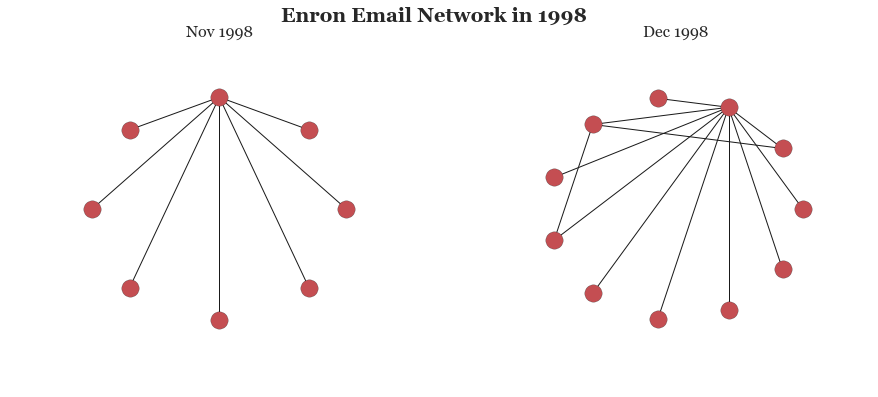

In [730]:
plt.figure()
plt.suptitle("Enron Email Network in 1998", fontsize=20)
plt.subplot(121)
plt.title("Nov 1998", fontsize=16)
nx.draw_circular(G_nov98)
plt.subplot(122)
plt.title("Dec 1998", fontsize=16)
nx.draw_circular(G_dec98)


In [731]:
stat_nov98 = cal_avgstat(G_nov98)
stat_dec98 = cal_avgstat(G_dec98)

In [732]:
stat_nov98

AvgDeg  AvgCloseness  AvgBet    AvgEig   AvgKatz  AvgLoad  MeanKurv  \
0  0.142857      0.192308   0.125  0.255427  0.185435    0.125 -0.186746   

   Density  AvgClustCoef   InstAmp  InstPhase  InstFreq.  EnergyEnv  \
0     0.25           0.0  1.673053   0.402325   0.148795   1.673053   

   dEnergyEnv  d2EnergyEnv  MeanResistanceDist   StatRat  
0    0.005621     0.018756             1.53125  0.894427

In [733]:
stat_dec98

AvgDeg  AvgCloseness    AvgBet   AvgEig   AvgKatz   AvgLoad  MeanKurv  \
0  0.145455      0.242737  0.086869  0.25114  0.175111  0.086869 -0.211928   

    Density  AvgClustCoef  InstAmp  InstPhase  InstFreq.  EnergyEnv  \
0  0.218182      0.155556  1.84759   0.249824   0.154485    1.84759   

   dEnergyEnv  d2EnergyEnv  MeanResistanceDist   StatRat  
0    0.016204    -0.001828             1.42562  0.915335

In [734]:
stat98= stat_nov98.append(stat_dec98).T

In [735]:
stat98.columns = ['Nov98','Dec98']

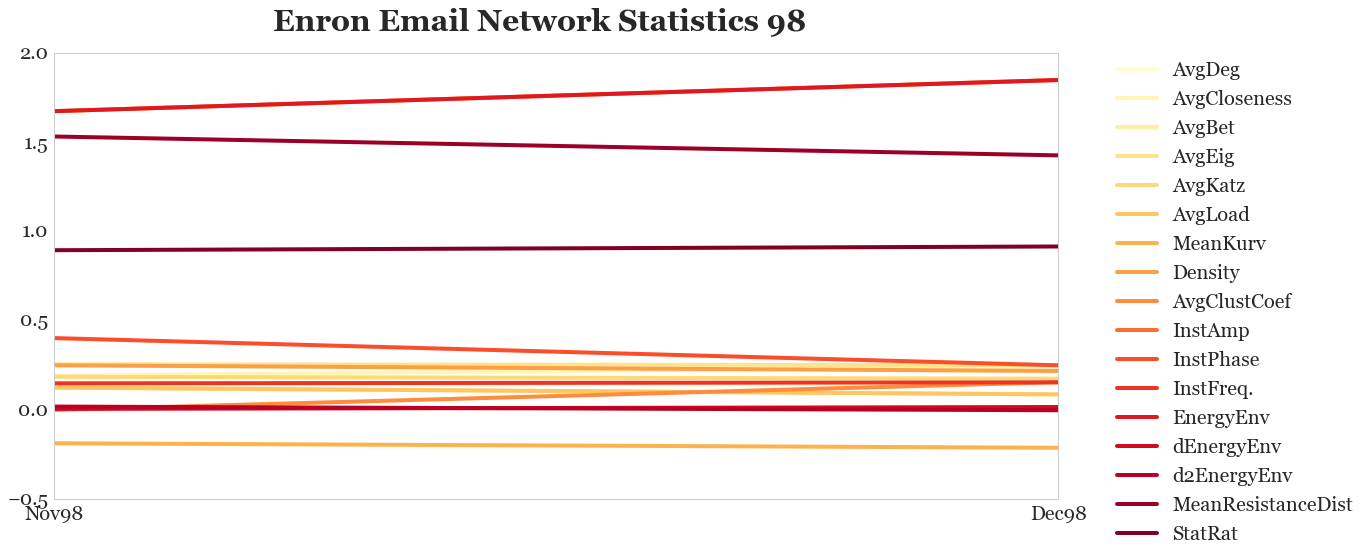

In [798]:
stat98.T.plot(fontsize=20, figsize=(18,8),cmap='YlOrRd')
plt.suptitle("Enron Email Network Statistics 98", fontsize=30)
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Network Year 1999

In [737]:
df_99.describe()

to          from    year        month
count  3715.000000  3715.000000  3715.0  3715.000000
mean    116.191386   115.949933  1999.0     9.725707
std      56.692443    43.626945     0.0     2.648675
min      11.000000     2.000000  1999.0     1.000000
25%      65.000000    88.000000  1999.0     8.000000
50%     145.000000   114.000000  1999.0    10.000000
75%     169.000000   156.000000  1999.0    12.000000
max     178.000000   178.000000  1999.0    12.000000

In [738]:
jan_99=df_99[df_99.month==1]
feb_99=df_99[df_99.month==2]
mar_99=df_99[df_99.month==3]
apr_99=df_99[df_99.month==4]
may_99=df_99[df_99.month==5]
jun_99=df_99[df_99.month==6]
jul_99=df_99[df_99.month==7]
aug_99=df_99[df_99.month==8]
sep_99=df_99[df_99.month==9]
oct_99=df_99[df_99.month==10]
nov_99=df_99[df_99.month==11]
dec_99=df_99[df_99.month==12]


G_jan_99=create_graph(jan_99)
G_feb_99=create_graph(feb_99)
G_mar_99=create_graph(mar_99)
G_apr_99=create_graph(apr_99)
G_may_99=create_graph(may_99)
G_jun_99=create_graph(jun_99)
G_jul_99=create_graph(jul_99)
G_aug_99=create_graph(aug_99)
G_sep_99=create_graph(sep_99)
G_oct_99=create_graph(oct_99)
G_nov_99=create_graph(nov_99)
G_dec_99=create_graph(dec_99)

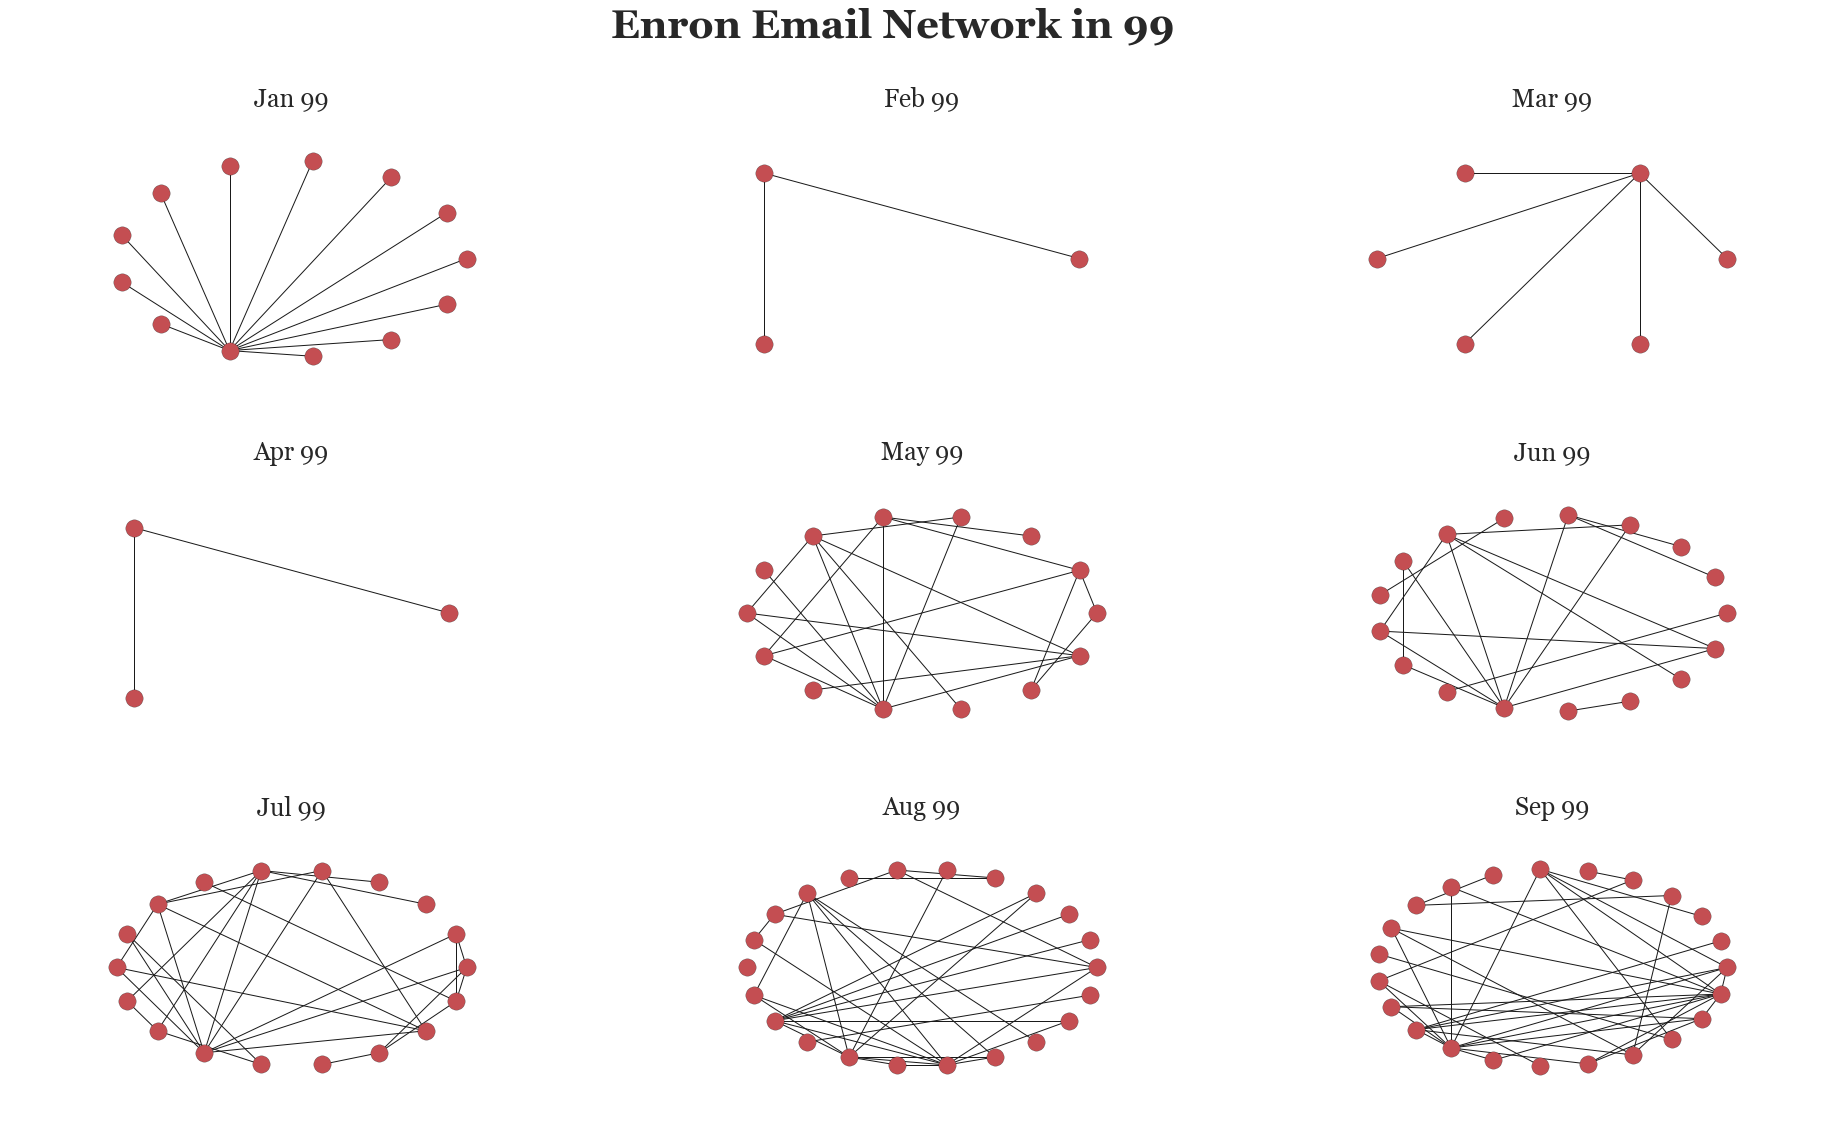

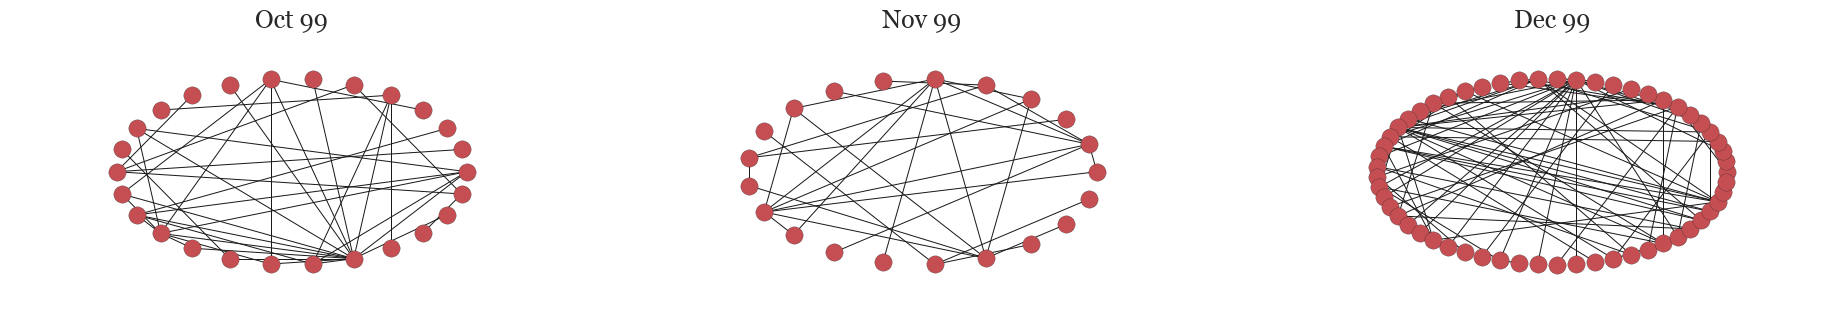

In [739]:
plt.figure(figsize=(32,18))
plt.suptitle("Enron Email Network in 99", fontsize=40)

plt.subplot(331)
plt.title("Jan 99", fontsize=25)
nx.draw_circular(G_jan_99)

plt.subplot(332)
plt.title("Feb 99", fontsize=25)
nx.draw_circular(G_feb_99)

plt.subplot(333)
plt.title("Mar 99", fontsize=25)
nx.draw_circular(G_mar_99)

plt.subplot(334)
plt.title("Apr 99", fontsize=25)
nx.draw_circular(G_apr_99)

plt.subplot(335)
plt.title("May 99", fontsize=25)
nx.draw_circular(G_may_99)

plt.subplot(336)
plt.title("Jun 99", fontsize=25)
nx.draw_circular(G_jun_99)

plt.subplot(337)
plt.title("Jul 99", fontsize=25)
nx.draw_circular(G_jul_99)

plt.subplot(338)
plt.title("Aug 99", fontsize=25)
nx.draw_circular(G_aug_99)

plt.subplot(339)
plt.title("Sep 99", fontsize=25)
nx.draw_circular(G_sep_99)

plt.figure(figsize=(32,5))
#plt.suptitle("Enron Email Network in 99", fontsize=40)

plt.subplot(131)
plt.title("Oct 99", fontsize=25)
nx.draw_circular(G_oct_99)

plt.subplot(132)
plt.title("Nov 99", fontsize=25)
nx.draw_circular(G_nov_99)

plt.subplot(133)
plt.title("Dec 99", fontsize=25)
nx.draw_circular(G_dec_99)

In [740]:
stat_jan_99=cal_avgstat(G_jan_99)
stat_feb_99=cal_avgstat(G_feb_99)
stat_mar_99=cal_avgstat(G_mar_99)
stat_apr_99=cal_avgstat(G_apr_99)
stat_may_99=cal_avgstat(G_may_99)
stat_jun_99=cal_avgstat(G_jun_99)
stat_jul_99=cal_avgstat(G_jul_99)
stat_aug_99=cal_avgstat(G_aug_99)
stat_sep_99=cal_avgstat(G_sep_99)
stat_oct_99=cal_avgstat(G_oct_99)
stat_nov_99=cal_avgstat(G_nov_99)
stat_dec_99=cal_avgstat(G_dec_99)

In [741]:
stat_99 = stat_jan_99.append(stat_feb_99).append(stat_mar_99).append(stat_apr_99).append(stat_may_99)
stat_99 = stat_99.append(stat_jun_99).append(stat_jul_99).append(stat_aug_99).append(stat_sep_99)
stat_99 = stat_99.append(stat_oct_99).append(stat_nov_99).append(stat_dec_99).T
stat_99.columns = ['jan_99','feb_99','mar_99','apr_99','may_99','jun_99','jul_99','aug_99','sep_99','oct_99','nov_99','dec_99']

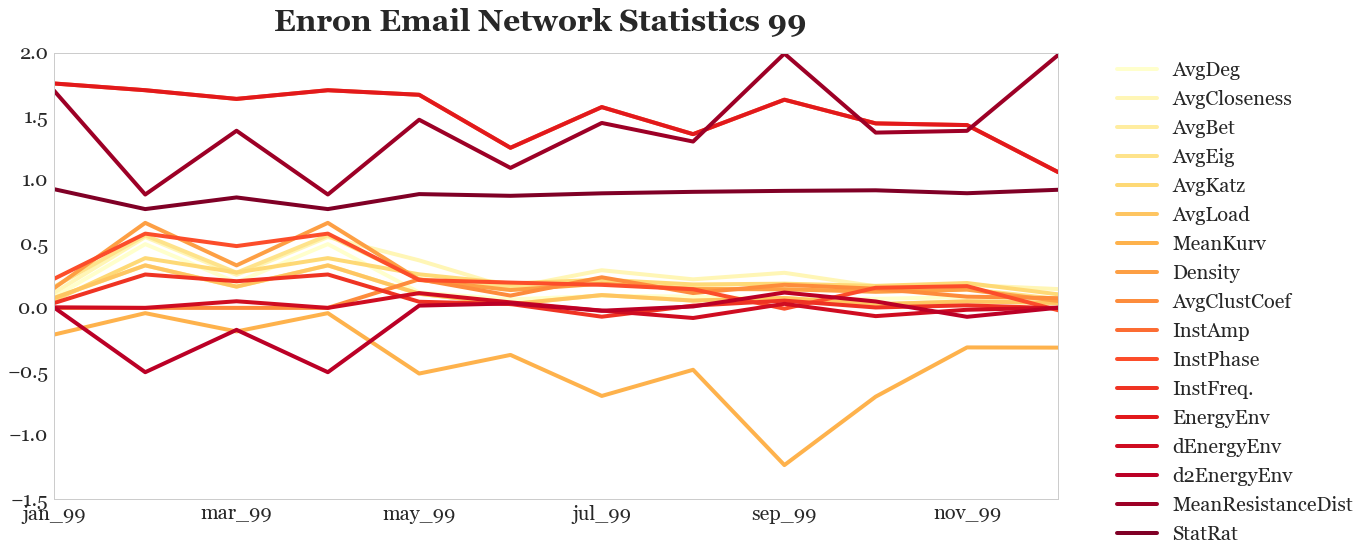

In [795]:
stat_99.T.plot(fontsize=20, figsize=(18,8), cmap='YlOrRd')
plt.suptitle("Enron Email Network Statistics 99", fontsize=30)
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Network Year 2000

In [742]:
df_2k.month.describe()

count    44059.000000
mean         8.183163
std          3.169912
min          1.000000
25%          6.000000
50%          9.000000
75%         11.000000
max         12.000000
Name: month, dtype: float64

In [743]:
jan_2k=df_2k[df_2k.month==1]
feb_2k=df_2k[df_2k.month==2]
mar_2k=df_2k[df_2k.month==3]
apr_2k=df_2k[df_2k.month==4]
may_2k=df_2k[df_2k.month==5]
jun_2k=df_2k[df_2k.month==6]
jul_2k=df_2k[df_2k.month==7]
aug_2k=df_2k[df_2k.month==8]
sep_2k=df_2k[df_2k.month==9]
oct_2k=df_2k[df_2k.month==10]
nov_2k=df_2k[df_2k.month==11]
dec_2k=df_2k[df_2k.month==12]


G_jan_2k=create_graph(jan_2k)
G_feb_2k=create_graph(feb_2k)
G_mar_2k=create_graph(mar_2k)
G_apr_2k=create_graph(apr_2k)
G_may_2k=create_graph(may_2k)
G_jun_2k=create_graph(jun_2k)
G_jul_2k=create_graph(jul_2k)
G_aug_2k=create_graph(aug_2k)
G_sep_2k=create_graph(sep_2k)
G_oct_2k=create_graph(oct_2k)
G_nov_2k=create_graph(nov_2k)
G_dec_2k=create_graph(dec_2k)

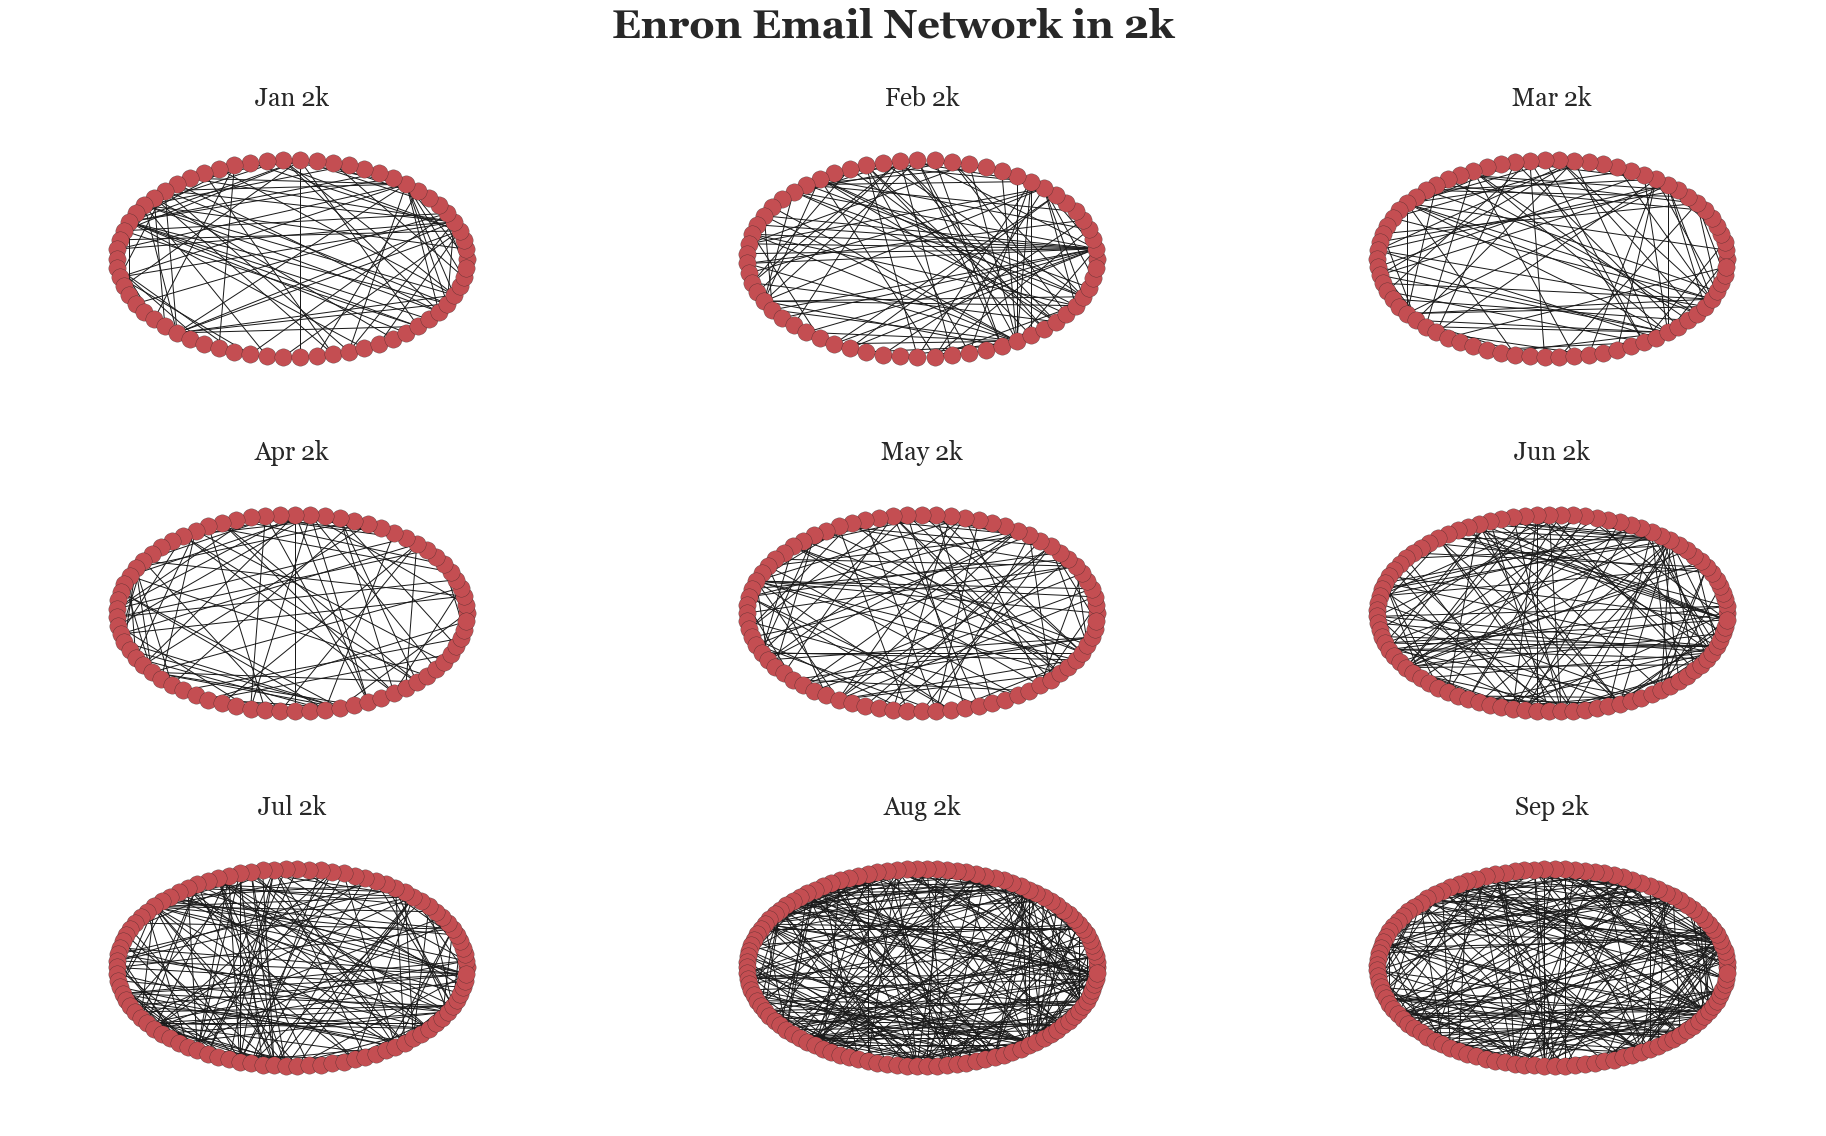

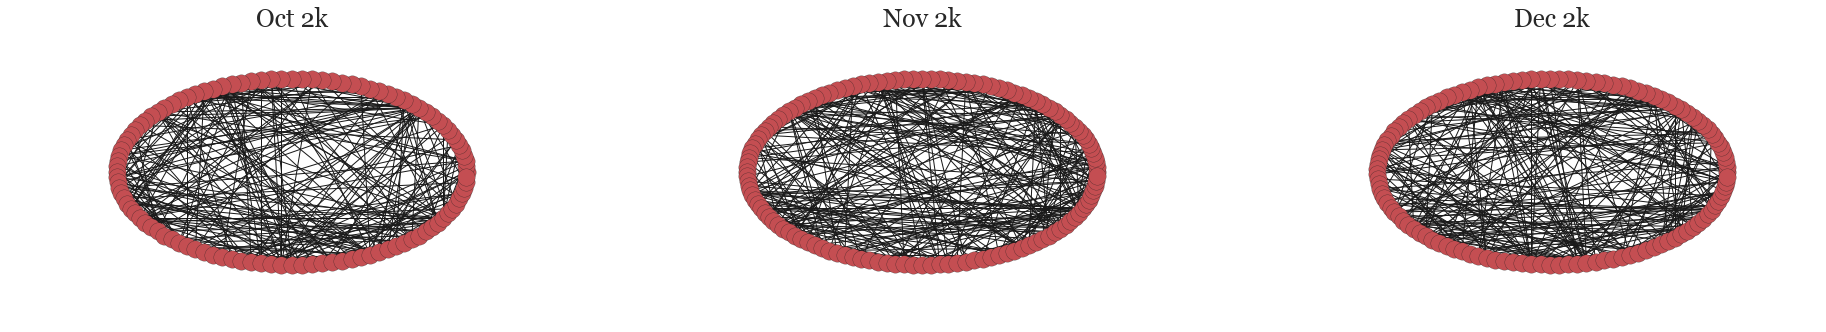

In [744]:
plt.figure(figsize=(32,18))
plt.suptitle("Enron Email Network in 2k", fontsize=40)

plt.subplot(331)
plt.title("Jan 2k", fontsize=25)
nx.draw_circular(G_jan_2k)

plt.subplot(332)
plt.title("Feb 2k", fontsize=25)
nx.draw_circular(G_feb_2k)

plt.subplot(333)
plt.title("Mar 2k", fontsize=25)
nx.draw_circular(G_mar_2k)

plt.subplot(334)
plt.title("Apr 2k", fontsize=25)
nx.draw_circular(G_apr_2k)

plt.subplot(335)
plt.title("May 2k", fontsize=25)
nx.draw_circular(G_may_2k)

plt.subplot(336)
plt.title("Jun 2k", fontsize=25)
nx.draw_circular(G_jun_2k)

plt.subplot(337)
plt.title("Jul 2k", fontsize=25)
nx.draw_circular(G_jul_2k)

plt.subplot(338)
plt.title("Aug 2k", fontsize=25)
nx.draw_circular(G_aug_2k)

plt.subplot(339)
plt.title("Sep 2k", fontsize=25)
nx.draw_circular(G_sep_2k)

plt.figure(figsize=(32,5))
#plt.suptitle("Enron Email Network in 2k", fontsize=40)

plt.subplot(131)
plt.title("Oct 2k", fontsize=25)
nx.draw_circular(G_oct_2k)

plt.subplot(132)
plt.title("Nov 2k", fontsize=25)
nx.draw_circular(G_nov_2k)

plt.subplot(133)
plt.title("Dec 2k", fontsize=25)
nx.draw_circular(G_dec_2k)

In [746]:
stat_jan_2k=cal_avgstat(G_jan_2k)
stat_feb_2k=cal_avgstat(G_feb_2k)
stat_mar_2k=cal_avgstat(G_mar_2k)
stat_apr_2k=cal_avgstat(G_apr_2k)
stat_may_2k=cal_avgstat(G_may_2k)
stat_jun_2k=cal_avgstat(G_jun_2k)
stat_jul_2k=cal_avgstat(G_jul_2k)
stat_aug_2k=cal_avgstat(G_aug_2k)
stat_sep_2k=cal_avgstat(G_sep_2k)
stat_oct_2k=cal_avgstat(G_oct_2k)
stat_nov_2k=cal_avgstat(G_nov_2k)
stat_dec_2k=cal_avgstat(G_dec_2k)

In [747]:
stat_2k = stat_jan_2k.append(stat_feb_2k).append(stat_mar_2k).append(stat_apr_2k).append(stat_may_2k)
stat_2k = stat_2k.append(stat_jun_2k).append(stat_jul_2k).append(stat_aug_2k).append(stat_sep_2k)
stat_2k = stat_2k.append(stat_oct_2k).append(stat_nov_2k).append(stat_dec_2k).T
stat_2k.columns = ['jan_2k','feb_2k','mar_2k','apr_2k','may_2k','jun_2k','jul_2k','aug_2k','sep_2k','oct_2k','nov_2k','dec_2k']

In [748]:
stat_2k.head()

jan_2k    feb_2k    mar_2k    apr_2k    may_2k    jun_2k  \
AvgDeg        0.022378  0.026626  0.014809  0.010464  0.014035  0.010867   
AvgCloseness  0.165628  0.208593  0.157985  0.113773  0.164460  0.192022   
AvgBet        0.034948  0.035326  0.046531  0.042264  0.033091  0.027877   
AvgEig        0.069247  0.084514  0.065003  0.053698  0.072435  0.068502   
AvgKatz       0.099556  0.104652  0.097354  0.103359  0.104188  0.091210   

                jul_2k    aug_2k    sep_2k    oct_2k    nov_2k    dec_2k  
AvgDeg        0.012697  0.016514  0.012147  0.018086  0.010884  0.013887  
AvgCloseness  0.206035  0.223131  0.192691  0.222388  0.177589  0.174585  
AvgBet        0.026787  0.017815  0.019417  0.019777  0.017789  0.019199  
AvgEig        0.068311  0.062979  0.062015  0.062333  0.054194  0.051451  
AvgKatz       0.086094  0.068437  0.073747  0.064164  0.058620  0.038943

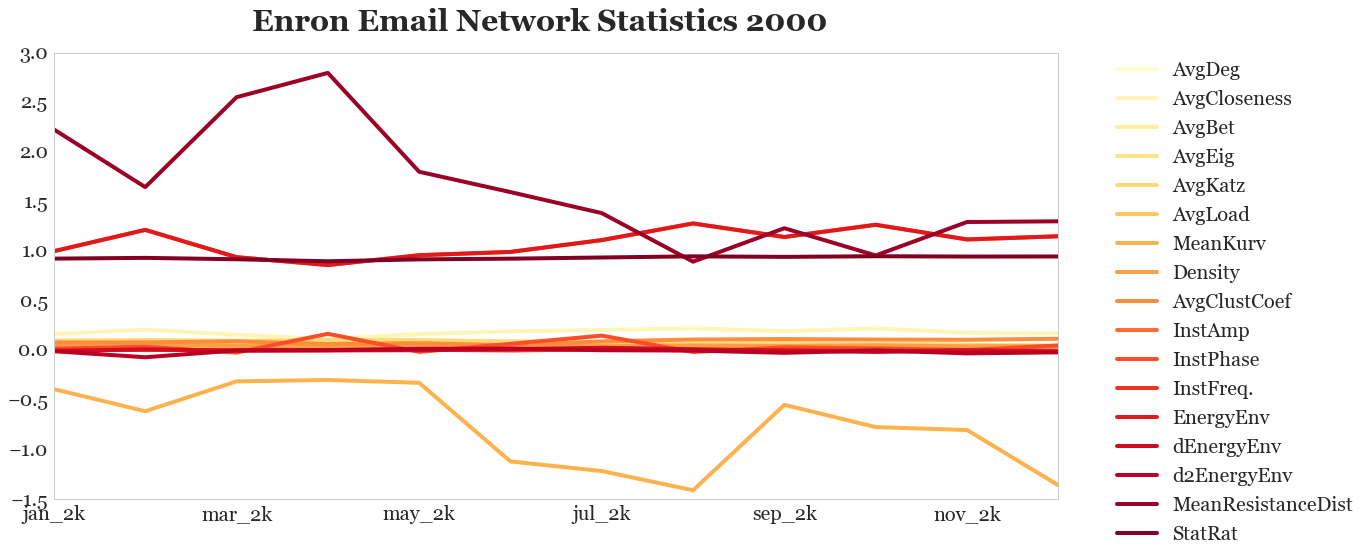

In [800]:
stat_2k.T.plot(fontsize=20, figsize=(18,8), cmap='YlOrRd')
plt.suptitle("Enron Email Network Statistics 2000", fontsize=30)
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Network Year 2k1

In [749]:
df_2k1.month.describe()

count    68888.000000
mean         6.125073
std          3.537309
min          1.000000
25%          3.000000
50%          5.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

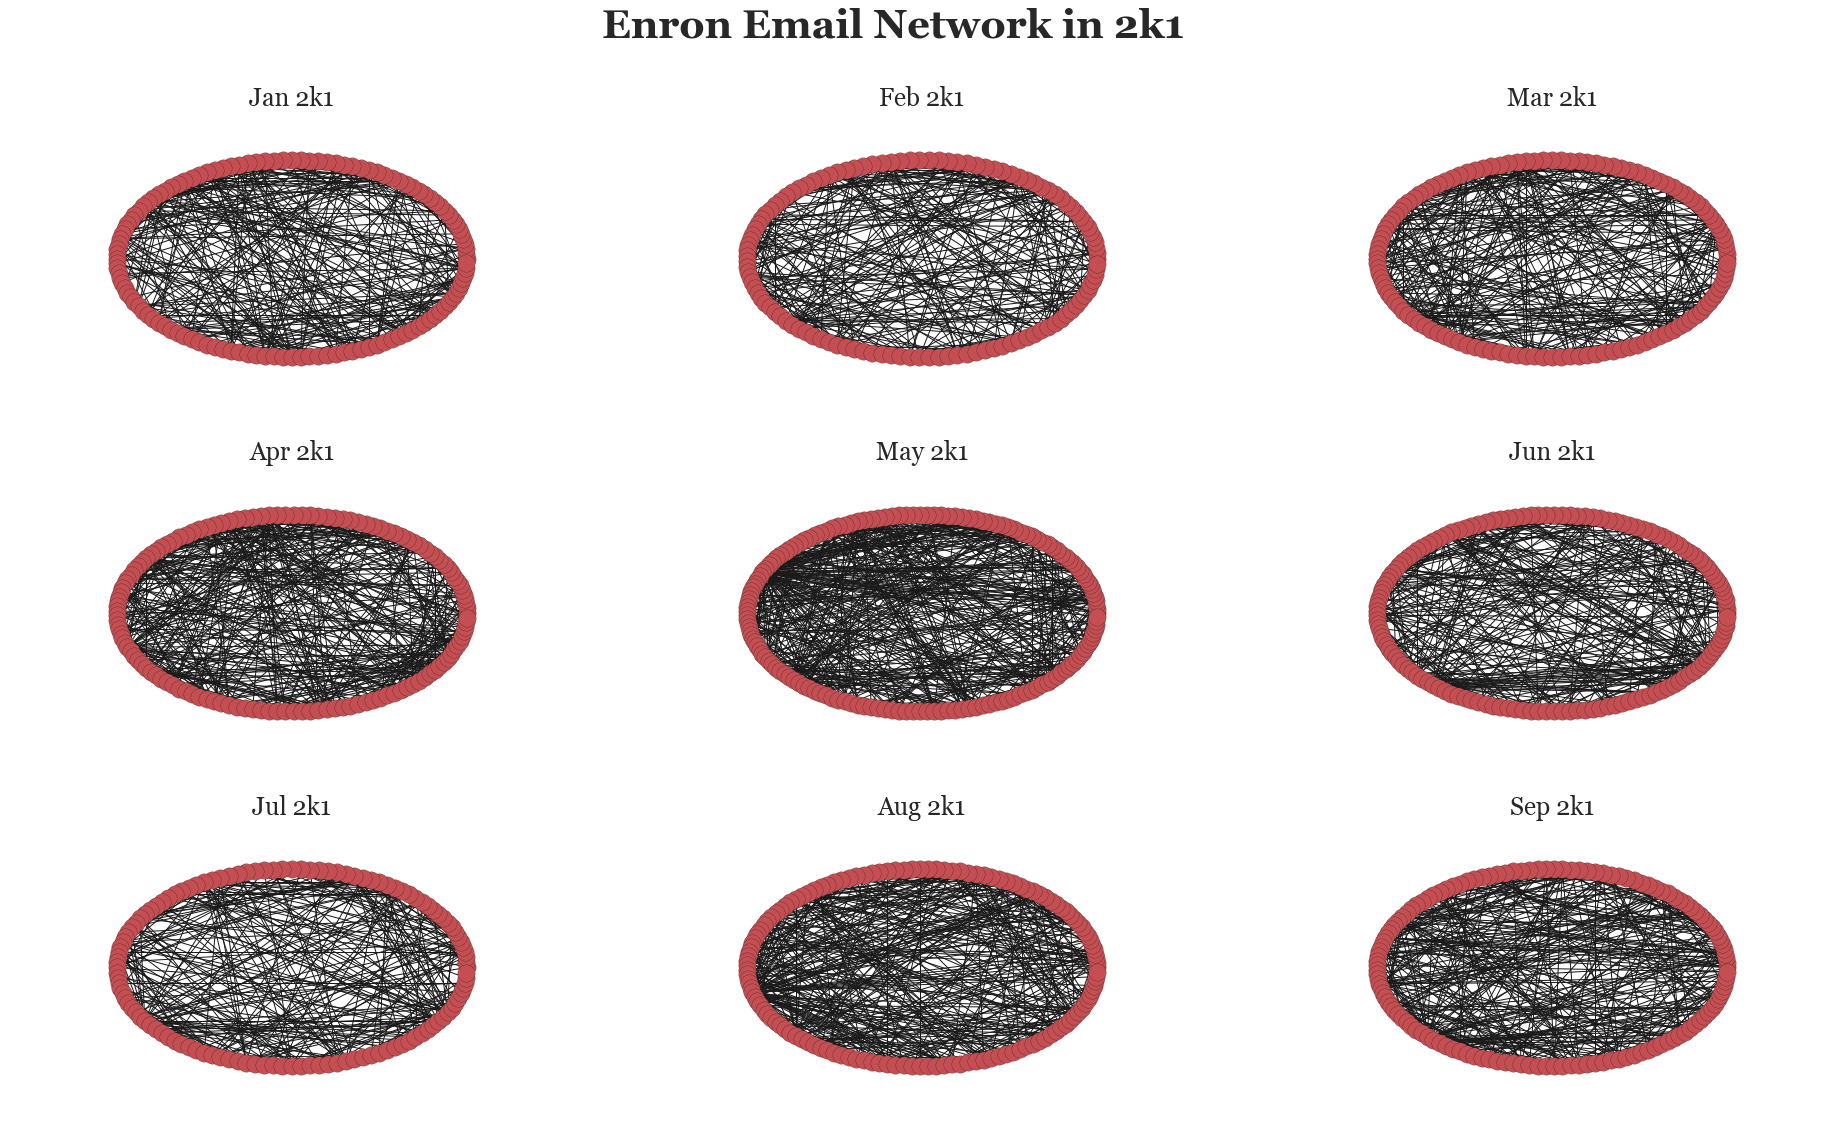

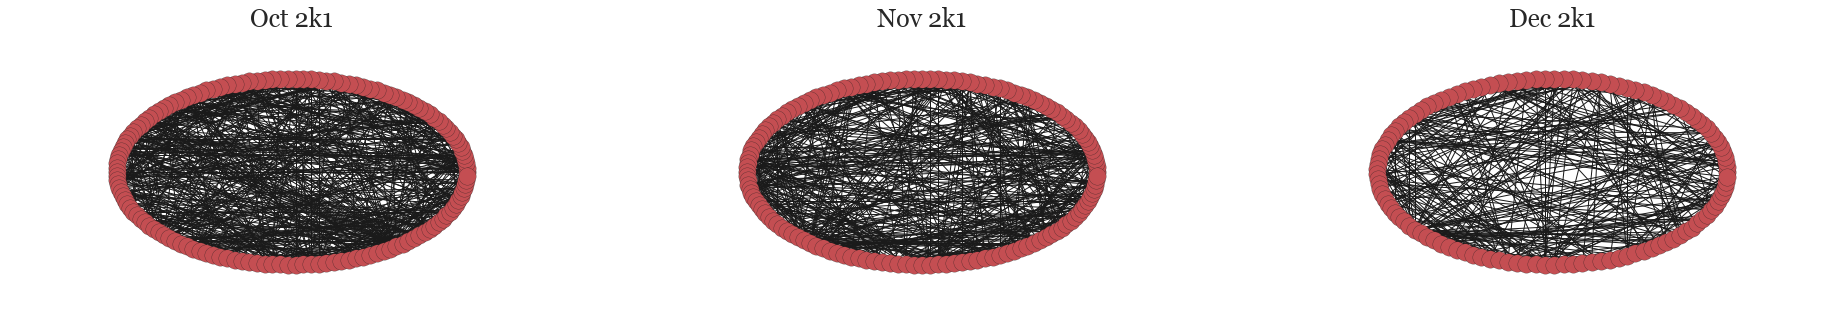

In [750]:
jan_2k1=df_2k1[df_2k1.month==1]
feb_2k1=df_2k1[df_2k1.month==2]
mar_2k1=df_2k1[df_2k1.month==3]
apr_2k1=df_2k1[df_2k1.month==4]
may_2k1=df_2k1[df_2k1.month==5]
jun_2k1=df_2k1[df_2k1.month==6]
jul_2k1=df_2k1[df_2k1.month==7]
aug_2k1=df_2k1[df_2k1.month==8]
sep_2k1=df_2k1[df_2k1.month==9]
oct_2k1=df_2k1[df_2k1.month==10]
nov_2k1=df_2k1[df_2k1.month==11]
dec_2k1=df_2k1[df_2k1.month==12]


G_jan_2k1=create_graph(jan_2k1)
G_feb_2k1=create_graph(feb_2k1)
G_mar_2k1=create_graph(mar_2k1)
G_apr_2k1=create_graph(apr_2k1)
G_may_2k1=create_graph(may_2k1)
G_jun_2k1=create_graph(jun_2k1)
G_jul_2k1=create_graph(jul_2k1)
G_aug_2k1=create_graph(aug_2k1)
G_sep_2k1=create_graph(sep_2k1)
G_oct_2k1=create_graph(oct_2k1)
G_nov_2k1=create_graph(nov_2k1)
G_dec_2k1=create_graph(dec_2k1)

plt.figure(figsize=(32,18))
plt.suptitle("Enron Email Network in 2k1", fontsize=40)

plt.subplot(331)
plt.title("Jan 2k1", fontsize=25)
nx.draw_circular(G_jan_2k1)

plt.subplot(332)
plt.title("Feb 2k1", fontsize=25)
nx.draw_circular(G_feb_2k1)

plt.subplot(333)
plt.title("Mar 2k1", fontsize=25)
nx.draw_circular(G_mar_2k1)

plt.subplot(334)
plt.title("Apr 2k1", fontsize=25)
nx.draw_circular(G_apr_2k1)

plt.subplot(335)
plt.title("May 2k1", fontsize=25)
nx.draw_circular(G_may_2k1)

plt.subplot(336)
plt.title("Jun 2k1", fontsize=25)
nx.draw_circular(G_jun_2k1)

plt.subplot(337)
plt.title("Jul 2k1", fontsize=25)
nx.draw_circular(G_jul_2k1)

plt.subplot(338)
plt.title("Aug 2k1", fontsize=25)
nx.draw_circular(G_aug_2k1)

plt.subplot(339)
plt.title("Sep 2k1", fontsize=25)
nx.draw_circular(G_sep_2k1)

plt.figure(figsize=(32,5))
#plt.suptitle("Enron Email Network in 2k1", fontsize=40)

plt.subplot(131)
plt.title("Oct 2k1", fontsize=25)
nx.draw_circular(G_oct_2k1)

plt.subplot(132)
plt.title("Nov 2k1", fontsize=25)
nx.draw_circular(G_nov_2k1)

plt.subplot(133)
plt.title("Dec 2k1", fontsize=25)
nx.draw_circular(G_dec_2k1)

In [751]:
stat_jan_2k1=cal_avgstat(G_jan_2k1)
stat_feb_2k1=cal_avgstat(G_feb_2k1)
stat_mar_2k1=cal_avgstat(G_mar_2k1)
stat_apr_2k1=cal_avgstat(G_apr_2k1)
stat_may_2k1=cal_avgstat(G_may_2k1)
stat_jun_2k1=cal_avgstat(G_jun_2k1)
stat_jul_2k1=cal_avgstat(G_jul_2k1)
stat_aug_2k1=cal_avgstat(G_aug_2k1)
stat_sep_2k1=cal_avgstat(G_sep_2k1)
stat_oct_2k1=cal_avgstat(G_oct_2k1)
stat_nov_2k1=cal_avgstat(G_nov_2k1)
stat_dec_2k1=cal_avgstat(G_dec_2k1)

stat_2k1 = stat_jan_2k1.append(stat_feb_2k1).append(stat_mar_2k1).append(stat_apr_2k1).append(stat_may_2k1)
stat_2k1 = stat_2k1.append(stat_jun_2k1).append(stat_jul_2k1).append(stat_aug_2k1).append(stat_sep_2k1)
stat_2k1 = stat_2k1.append(stat_oct_2k1).append(stat_nov_2k1).append(stat_dec_2k1).T
stat_2k1.columns = ['jan_2k1','feb_2k1','mar_2k1','apr_2k1','may_2k1','jun_2k1','jul_2k1','aug_2k1','sep_2k1','oct_2k1','nov_2k1','dec_2k1']

In [752]:
stat_2k1.head()

jan_2k1   feb_2k1   mar_2k1   apr_2k1   may_2k1   jun_2k1  \
AvgDeg        0.013179  0.012052  0.012982  0.015607  0.012401  0.008815   
AvgCloseness  0.191559  0.208446  0.186307  0.214056  0.221824  0.209019   
AvgBet        0.017710  0.021867  0.017525  0.017928  0.011548  0.019936   
AvgEig        0.055170  0.064597  0.058794  0.051706  0.053974  0.048988   
AvgKatz       0.048244  0.074620  0.057339  0.002995  0.022108  0.059015   

               jul_2k1   aug_2k1   sep_2k1   oct_2k1   nov_2k1   dec_2k1  
AvgDeg        0.016036  0.016639  0.012930  0.019379  0.016612  0.011789  
AvgCloseness  0.199306  0.247621  0.195912  0.232163  0.241737  0.202481  
AvgBet        0.020539  0.015186  0.021407  0.012743  0.017048  0.022688  
AvgEig        0.053507  0.051803  0.051587  0.058752  0.056969  0.065293  
AvgKatz       0.046579  0.000057  0.021531  0.003949  0.002392  0.074214

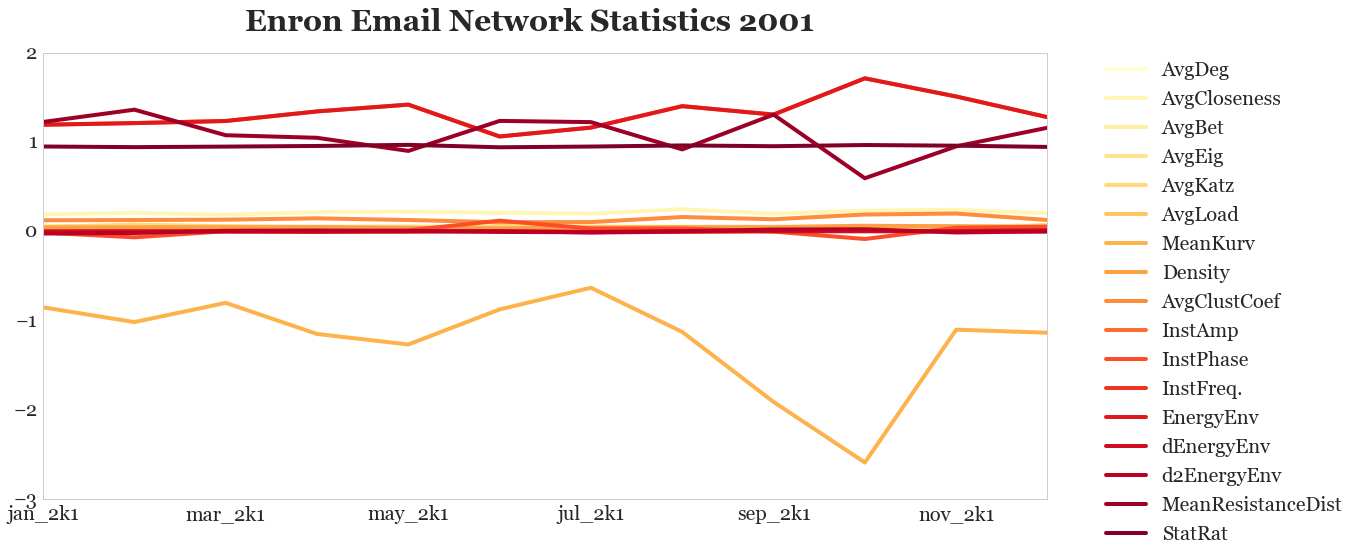

In [801]:
stat_2k1.T.plot(fontsize=20, figsize=(18,8), cmap='YlOrRd')
plt.suptitle("Enron Email Network Statistics 2001", fontsize=30)
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Network Year 2k2

In [753]:
df_2k2.month.describe()

count    8491.000000
mean        1.758921
std         0.807467
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: month, dtype: float64

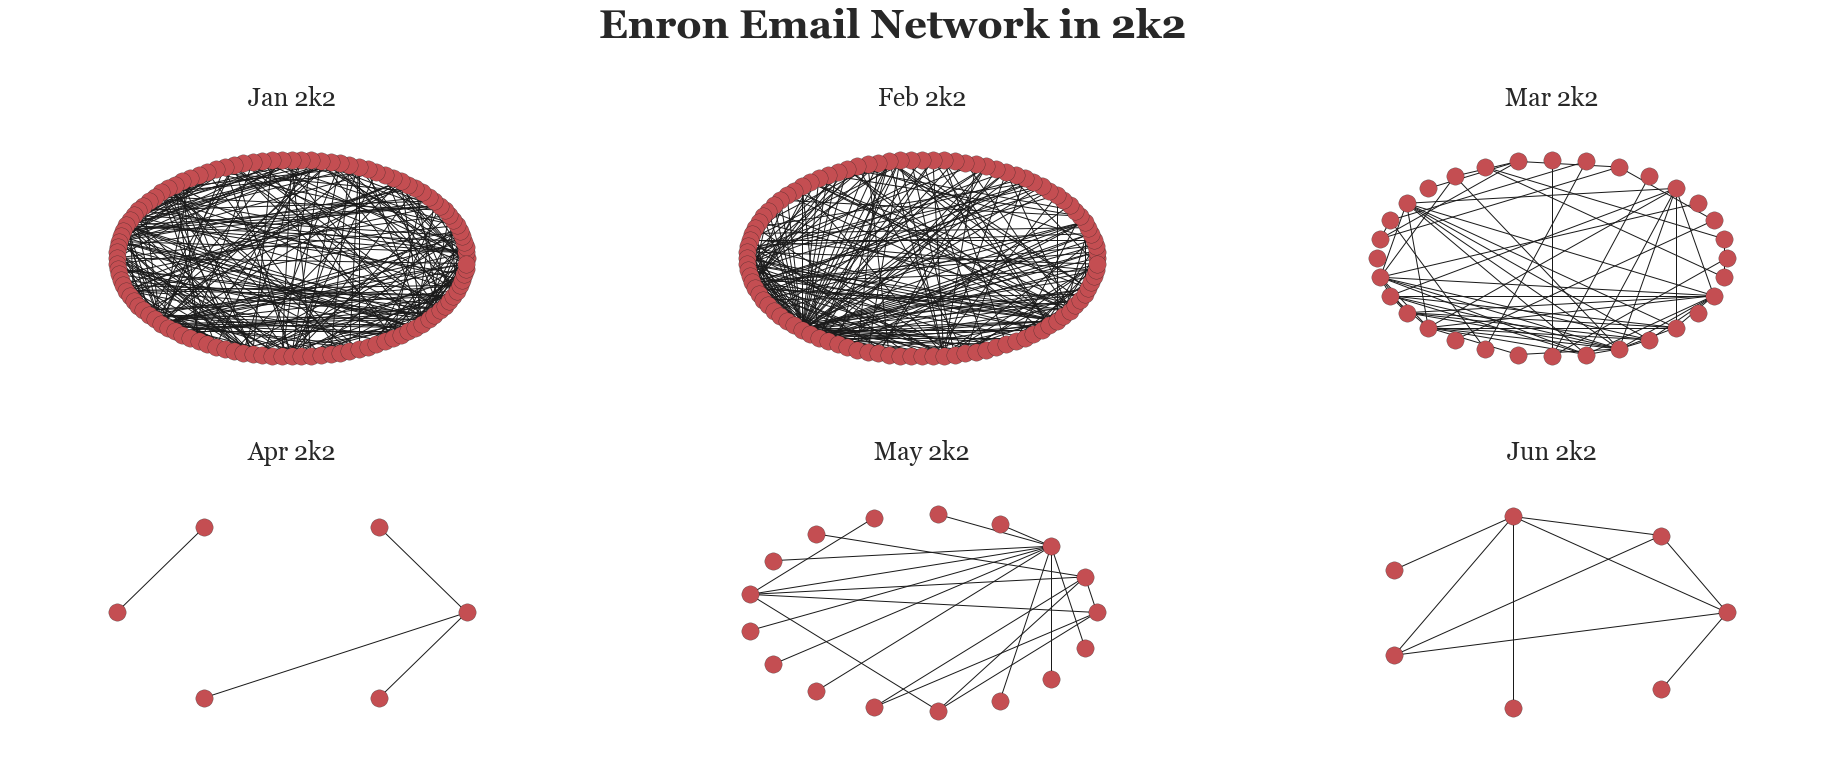

In [754]:
jan_2k2=df_2k2[df_2k2.month==1]
feb_2k2=df_2k2[df_2k2.month==2]
mar_2k2=df_2k2[df_2k2.month==3]
apr_2k2=df_2k2[df_2k2.month==4]
may_2k2=df_2k2[df_2k2.month==5]
jun_2k2=df_2k2[df_2k2.month==6]
jul_2k2=df_2k2[df_2k2.month==7]
aug_2k2=df_2k2[df_2k2.month==8]
sep_2k2=df_2k2[df_2k2.month==9]
oct_2k2=df_2k2[df_2k2.month==10]
nov_2k2=df_2k2[df_2k2.month==11]
dec_2k2=df_2k2[df_2k2.month==12]


G_jan_2k2=create_graph(jan_2k2)
G_feb_2k2=create_graph(feb_2k2)
G_mar_2k2=create_graph(mar_2k2)
G_apr_2k2=create_graph(apr_2k2)
G_may_2k2=create_graph(may_2k2)
G_jun_2k2=create_graph(jun_2k2)
G_jul_2k2=create_graph(jul_2k2)
G_aug_2k2=create_graph(aug_2k2)
G_sep_2k2=create_graph(sep_2k2)
G_oct_2k2=create_graph(oct_2k2)
G_nov_2k2=create_graph(nov_2k2)
G_dec_2k2=create_graph(dec_2k2)

plt.figure(figsize=(32,18))
plt.suptitle("Enron Email Network in 2k2", fontsize=40)

plt.subplot(331)
plt.title("Jan 2k2", fontsize=25)
nx.draw_circular(G_jan_2k2)

plt.subplot(332)
plt.title("Feb 2k2", fontsize=25)
nx.draw_circular(G_feb_2k2)

plt.subplot(333)
plt.title("Mar 2k2", fontsize=25)
nx.draw_circular(G_mar_2k2)

plt.subplot(334)
plt.title("Apr 2k2", fontsize=25)
nx.draw_circular(G_apr_2k2)

plt.subplot(335)
plt.title("May 2k2", fontsize=25)
nx.draw_circular(G_may_2k2)

plt.subplot(336)
plt.title("Jun 2k2", fontsize=25)
nx.draw_circular(G_jun_2k2)


In [755]:
stat_jan_2k2=cal_avgstat(G_jan_2k2)
stat_feb_2k2=cal_avgstat(G_feb_2k2)
stat_mar_2k2=cal_avgstat(G_mar_2k2)
stat_apr_2k2=cal_avgstat(G_apr_2k2)
stat_may_2k2=cal_avgstat(G_may_2k2)
stat_jun_2k2=cal_avgstat(G_jun_2k2)

stat_2k2 = stat_jan_2k2.append(stat_feb_2k2).append(stat_mar_2k2).append(stat_apr_2k2).append(stat_may_2k2).append(stat_jun_2k2).T
stat_2k2.columns = ['jan_2k2','feb_2k2','mar_2k2','apr_2k2','may_2k2','jun_2k2']

In [756]:
stat_2k2.head()

jan_2k2   feb_2k2   mar_2k2   apr_2k2   may_2k2   jun_2k2
AvgDeg        0.018018  0.021818  0.049395  0.200000  0.106618  0.357143
AvgCloseness  0.191514  0.193146  0.133727  0.193333  0.234243  0.462193
AvgBet        0.022664  0.022488  0.033737  0.050000  0.094118  0.133333
AvgEig        0.055595  0.065003  0.108396  0.248878  0.168015  0.336275
AvgKatz       0.042359  0.046586  0.131887  0.277666  0.212198  0.273203

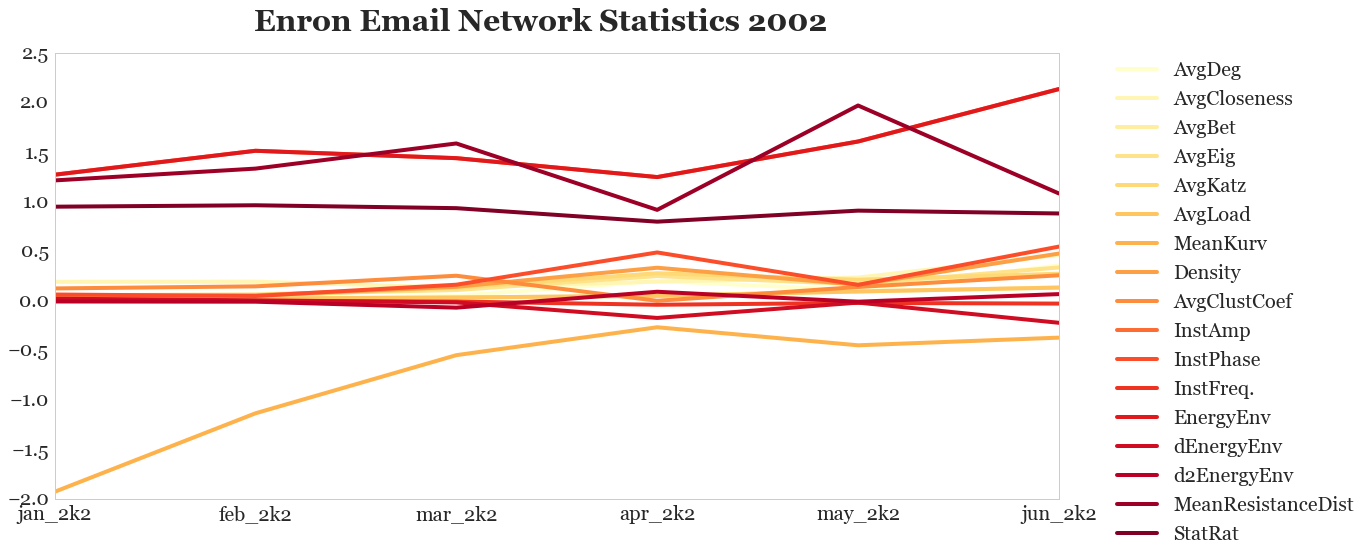

In [802]:
stat_2k2.T.plot(fontsize=20, figsize=(18,8), cmap='YlOrRd')
plt.suptitle("Enron Email Network Statistics 2002", fontsize=30)
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

 # Network Attributes over full time range

In [757]:
stat_all = stat98.join(stat_99).join(stat_2k).join(stat_2k1).join(stat_2k2).T

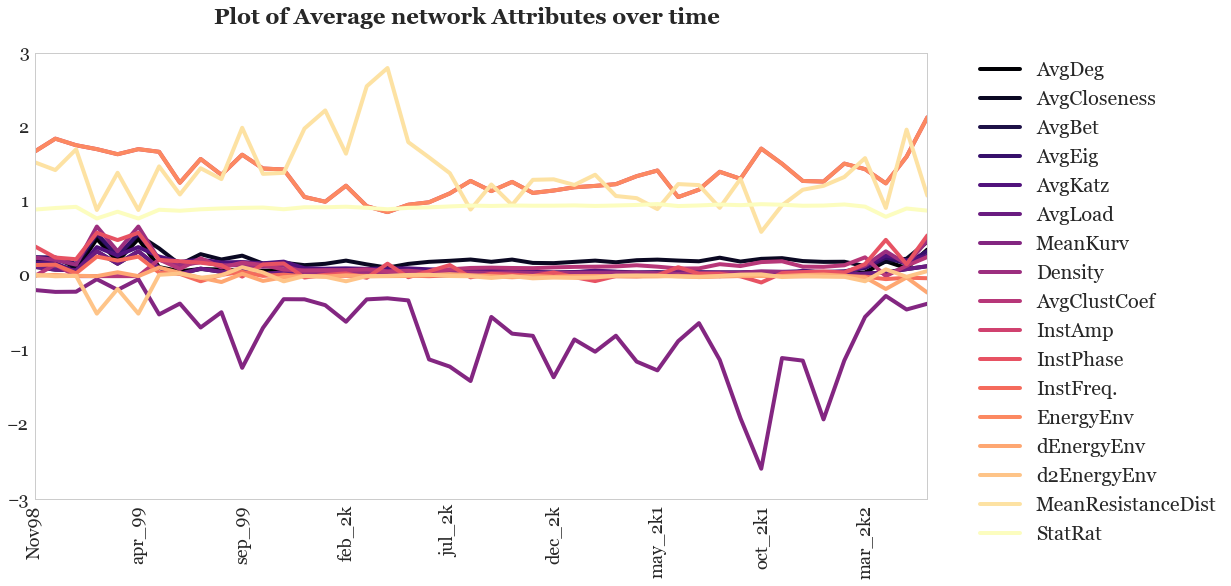

In [940]:
stat_all.plot(figsize=(16,8), fontsize=18, rot=90,cmap='magma')
plt.suptitle("Plot of Average network Attributes over time", fontsize=22)
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

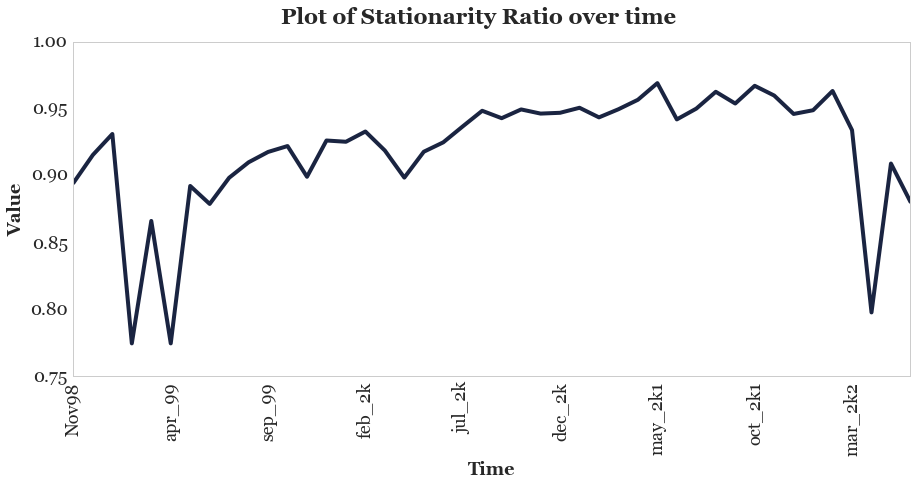

In [759]:
stat_all.StatRat.plot(fontsize=18, rot=90)
plt.suptitle('Plot of Stationarity Ratio over time', fontsize=22)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Value", fontsize=18)

In [760]:
stat_all_std = stat_all - stat_all.mean()/ stat_all.std()

In [761]:
stat_all_std.head()

AvgDeg  AvgCloseness    AvgBet    AvgEig   AvgKatz   AvgLoad  \
Nov98  -0.501559     -2.190459 -0.683674 -0.811947 -1.049629 -0.683703   
Dec98  -0.498961     -2.140030 -0.721805 -0.816233 -1.059953 -0.721834   
jan_99 -0.561083     -2.265710 -0.731751 -0.903068 -1.177372 -0.731780   
feb_99 -0.144416     -1.827211 -0.475340 -0.498338 -0.844841 -0.475370   
mar_99 -0.444416     -2.123508 -0.642007 -0.791408 -0.957380 -0.642036   

        MeanKurv   Density  AvgClustCoef   InstAmp  InstPhase  InstFreq.  \
Nov98   1.223986 -0.614423     -1.728109 -3.234486  -0.322693  -0.213067   
Dec98   1.198805 -0.646242     -1.572554 -3.059949  -0.475194  -0.207377   
jan_99  1.201116 -0.710577     -1.728109 -3.148094  -0.497733  -0.324490   
feb_99  1.369452 -0.197757     -1.728109 -3.200872  -0.142786  -0.100063   
mar_99  1.225887 -0.531090     -1.728109 -3.269003  -0.240465  -0.152871   

        EnergyEnv  dEnergyEnv  d2EnergyEnv  MeanResistanceDist    StatRat  
Nov98   -3.234486    0.136924     0.231110           -1.554605 -19.387492  
Dec98   -3.059949    0.147507     0.210526           -1.660235 -19.366584  
jan_99  -3.148094    0.135652     0.216238           -1.381713 -19.350969  
feb_99  -3.200872    0.131303    -0.291969           -2.196966 -19.507322  
mar_99  -3.269003    0.183316     0.040216           -1.696966 -19.415893

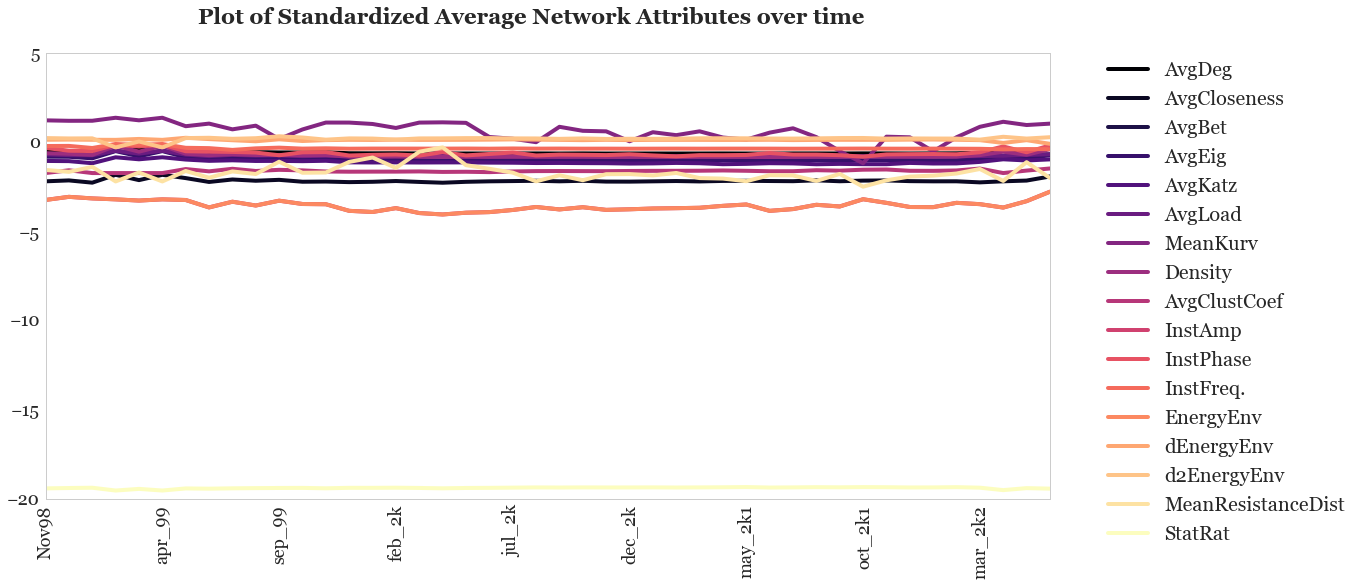

In [942]:
stat_all_std.plot(figsize=(18,8), cmap='magma',fontsize=18, rot=90)
plt.suptitle("Plot of Standardized Average Network Attributes over time", fontsize=22)
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Persistence and Emergence

In [763]:
persistence = stat_all_std.T.mean()/stat_all_std.T.shape[0]

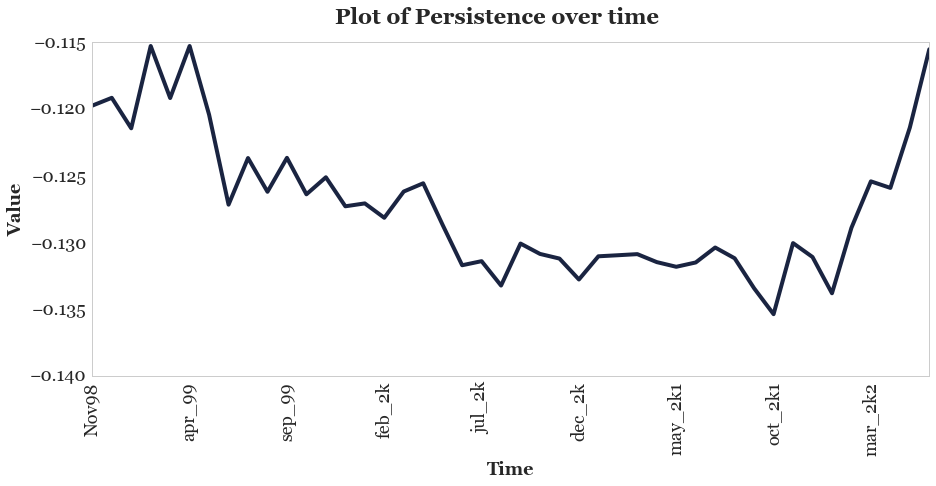

In [764]:
persistence.plot(fontsize=18, rot=90)
plt.suptitle("Plot of Persistence over time", fontsize=22)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Value", fontsize=18)

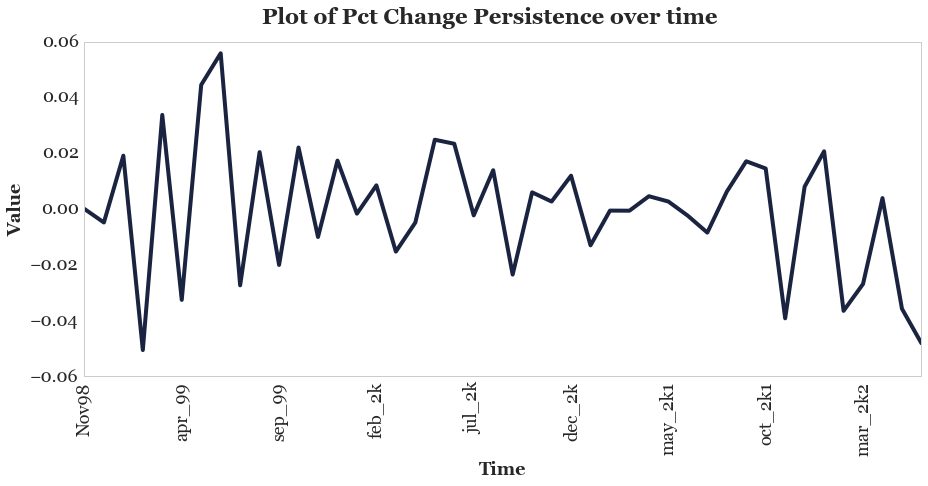

In [765]:
persistence.pct_change().fillna(0).plot(fontsize=18, rot=90)
plt.suptitle("Plot of Pct Change Persistence over time", fontsize=22)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Value", fontsize=18)

In [766]:
def emergence(a,b):
    e = (a-b)/ (np.linalg.norm(a)+np.linalg.norm(b))
    return e

In [767]:
emerg = []
for i in range(0,persistence.shape[0]-1):
    x = int(i)
    y = x +1
    emerg.append(emergence(persistence.values[y],persistence.values[x]))

In [768]:
emerg_df = pd.DataFrame(emerg).T
emerg_df.columns = list(stat_all.T.columns)[1:]
emerg_df = emerg_df.T
emerg_df.columns = ['Emergence']

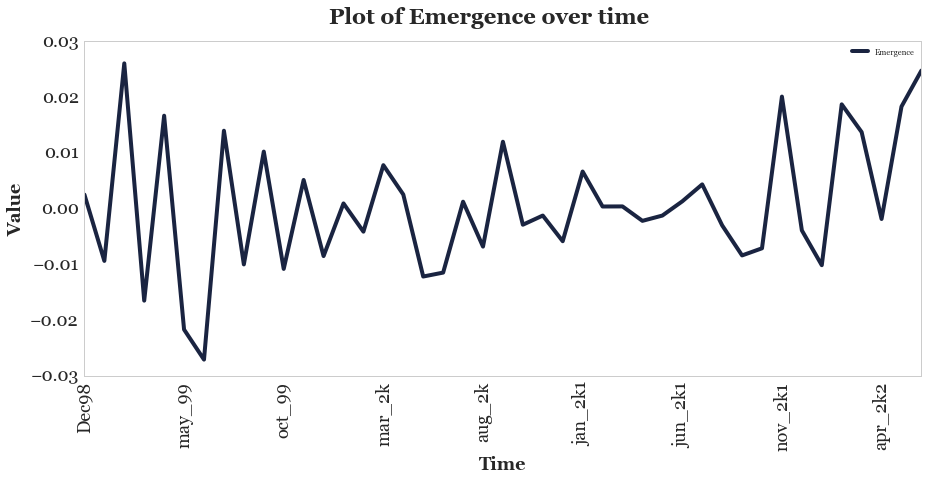

In [769]:
emerg_df.plot(fontsize=18, rot=90)
plt.suptitle("Plot of Emergence over time", fontsize=22)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Value", fontsize=18)

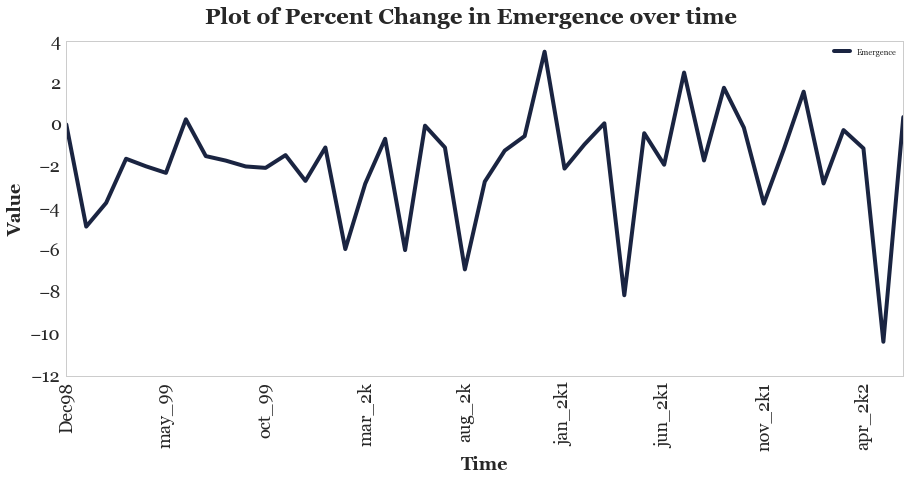

In [770]:
emerg_df.pct_change().fillna(0).plot(fontsize=18, rot=90)
plt.suptitle("Plot of Percent Change in Emergence over time", fontsize=22)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Value", fontsize=18)

C:\Users\arsha_000\Anaconda3\lib\site-packages\numpy\core\numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


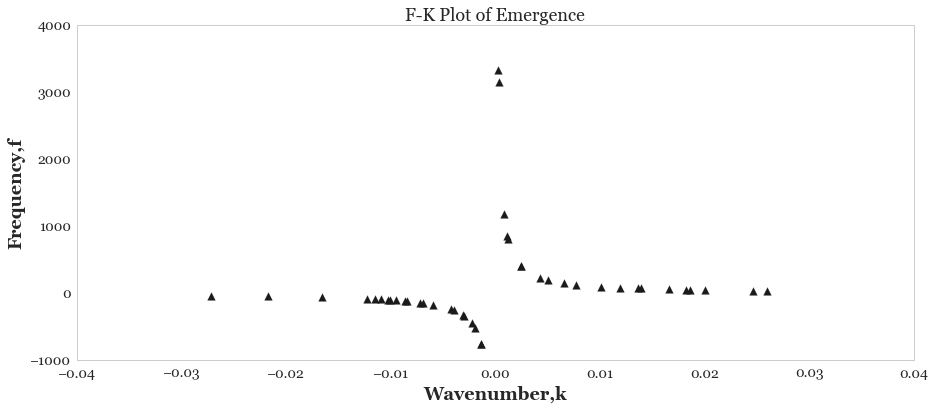

In [771]:
freq = sc.fft(emerg_df)
wavnumber = 1/freq

plt.scatter(freq, wavnumber, s=60, marker='^', c='k')
plt.title("F-K Plot of Emergence", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Wavenumber,k", fontsize=18)
plt.ylabel("Frequency,f", fontsize=18)

In [772]:
print("Maximum Frequency :\n", emerg_df.iloc[np.argmax(freq)])
print("-----------------\n")
print("Minimum Frequency :\n", emerg_df.iloc[np.argmin(freq)])

Maximum Frequency :
 Emergence    0.025951
Name: feb_99, dtype: float64
-----------------

Minimum Frequency :
 Emergence   -0.027137
Name: jun_99, dtype: float64


In [773]:
def plot_radon(m, name):
    from skimage.transform import radon
    theta = np.linspace(0., 180., max(m.shape), endpoint=False)
    sinogram = radon(m, theta=theta, circle=True)
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].scatter(sinogram[0], sinogram[1], s=60, marker='^', c='k')
    ax[0].set_title("Radon Transform Plot of "+str(name), fontsize=14)
 
    
    ax[1].scatter(1/sinogram[0], sinogram[1], s=60, marker='^', c='r')
    ax[1].set_title("1/Radon[0] vs Radon[1] Plot of "+str(name), fontsize=14)

    
    plt.show()

C:\Users\arsha_000\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:66: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


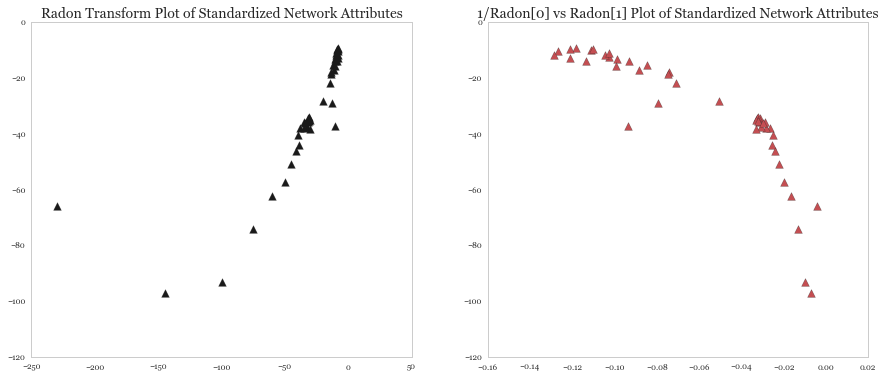

In [774]:
plot_radon(stat_all_std.values,'Standardized Network Attributes')

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5]),
 <a list of 17 Text yticklabel objects>)

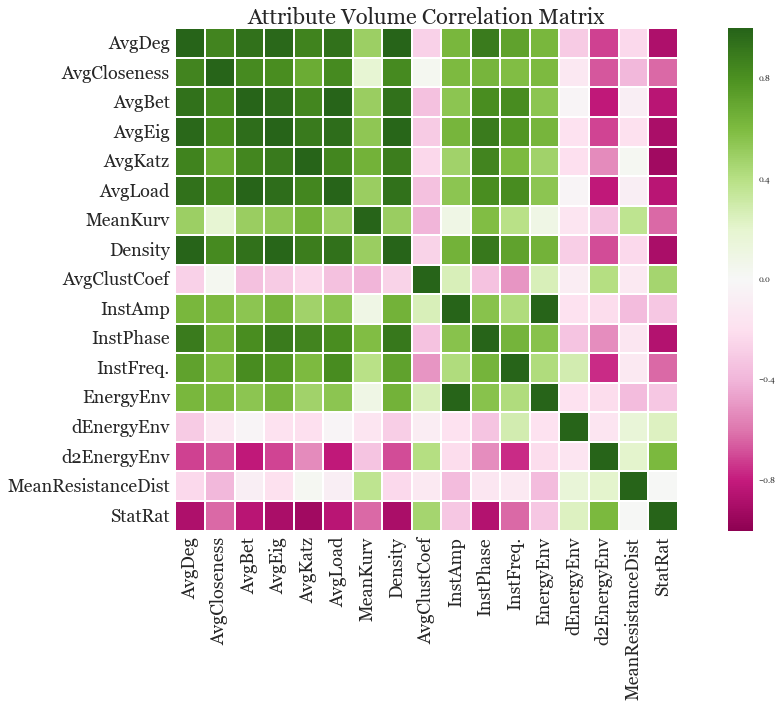

In [908]:
plt.figure(figsize=(18,9))
sns.heatmap(stat_all_std.corr(), cmap='PiYG',robust=True, fmt='d', linewidths=1, square=True)
plt.title("Attribute Volume Correlation Matrix", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Subgraph Stationarity

In [815]:
def pad_shape(x,ref,offset=0):
    result = np.zeros_like(ref)
    result[0:x.shape[0]+0,0:x.shape[1]+0] = x
    
    return result

In [838]:
all_graphs = tuple([G_nov98,G_dec98,G_jan_99,G_feb_99,G_mar_99,G_apr_99,G_may_99,G_jun_99,G_jul_99,G_aug_99,G_sep_99,G_oct_99,\
              G_nov_99,G_dec_99,G_jan_2k,G_feb_2k,G_mar_2k,G_apr_2k,G_may_2k,G_jun_2k,G_jul_2k,G_aug_2k,G_sep_2k,\
              G_oct_2k,G_nov_2k,G_dec_2k,G_jan_2k1,G_feb_2k1,G_mar_2k1,G_apr_2k1,G_may_2k1,G_jun_2k1,G_jul_2k1,\
              G_aug_2k1,G_sep_2k1,G_oct_2k1,G_nov_2k1,G_dec_2k1,G_jan_2k2,G_feb_2k2,G_mar_2k2,G_apr_2k2,G_may_2k2,G_jun_2k2])

In [909]:
all_graphs[:5]

(<networkx.classes.graph.Graph at 0x1489f391ba8>,
 <networkx.classes.graph.Graph at 0x148f102b0b8>)

In [913]:
def subgraph_stat(net1,net2):
    net1_int_net2 = net1.copy()
    net1_int_net2.remove_nodes_from(n for n in net1 if n not in net2)
    net1_u_net2 = nx.disjoint_union(net1, net2)
    int_adjmat = nx.adjacency_matrix(net1_int_net2).todense()
    uni_adjmat = nx.adjacency_matrix(net1_u_net2).todense()
    int_adjmat_pad = pad_shape(int_adjmat,uni_adjmat)
    
    Ct = np.divide(norm(int_adjmat_pad),norm(uni_adjmat))
    
    return Ct

In [923]:
Ct = []
for i in range(0,len(all_graphs)-1):
    x = int(i)
    y = x +1
    Ct.append(subgraph_stat(all_graphs[x],all_graphs[y]))

(array([ 0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 7 Text yticklabel objects>)

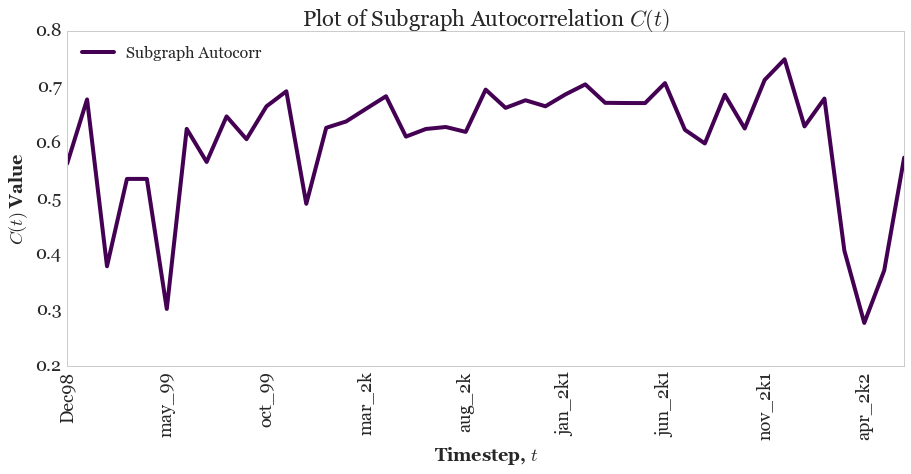

In [972]:
Ct_df = pd.DataFrame(Ct, columns=['Subgraph Autocorr']).T
Ct_df.columns = list(stat_all.T.columns)[1:]
Ct_df = Ct_df.T

Ct_df.plot(fontsize=18, cmap='viridis', rot = 90)
plt.title("Plot of Subgraph Autocorrelation $C(t)$", fontsize=22)
plt.xlabel("Timestep, $t$", fontsize=18)
plt.ylabel("$C(t)$ Value", fontsize=18)
plt.legend(fontsize=16, loc=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [968]:
zeta = Ct_df.cumsum(axis=1)/(Ct_df.shape[0]-1)
zeta =  zeta.T
zeta.columns = list(stat_all.T.columns)[1:]
zeta = zeta.T
zeta.columns = ['Zeta']
zeta.head()

Zeta
Dec98   0.013380
jan_99  0.016119
feb_99  0.008999
mar_99  0.012727
apr_99  0.012727

(array([ 0.006,  0.008,  0.01 ,  0.012,  0.014,  0.016,  0.018,  0.02 ]),
 <a list of 8 Text yticklabel objects>)

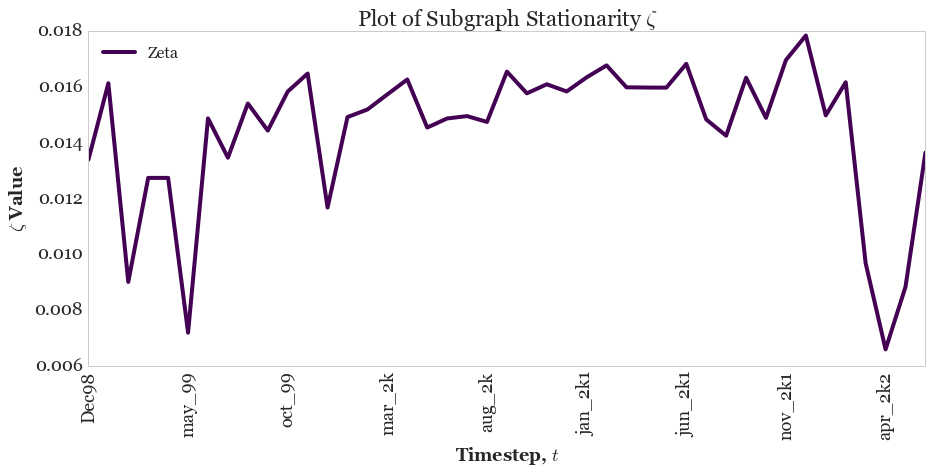

In [970]:
zeta.plot(fontsize=18, cmap='viridis', rot =90)
plt.title("Plot of Subgraph Stationarity $\zeta$", fontsize=22)
plt.xlabel("Timestep, $t$", fontsize=18)
plt.ylabel("$\zeta$ Value", fontsize=18)
plt.legend(fontsize=16, loc=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <a list of 6 Text yticklabel objects>)

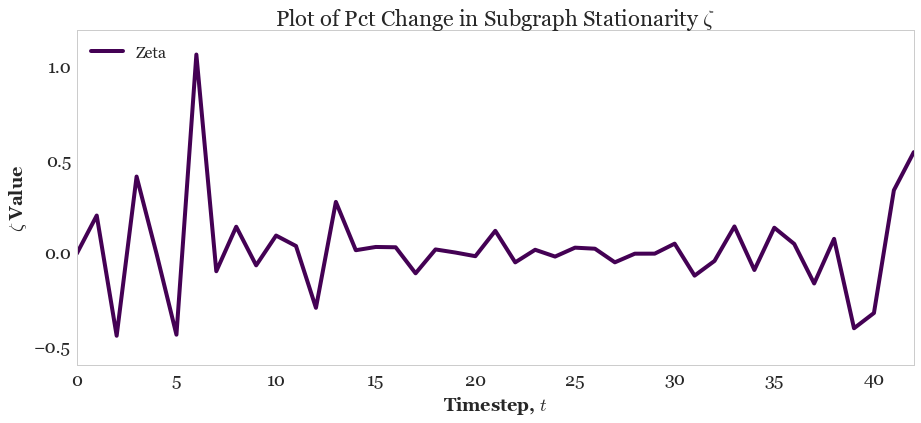

In [962]:
zeta.pct_change().fillna(0).plot(fontsize=18, cmap='viridis')
plt.title("Plot of Pct Change in Subgraph Stationarity $\zeta$", fontsize=22)
plt.xlabel("Timestep, $t$", fontsize=18)
plt.ylabel("$\zeta$ Value", fontsize=18)
plt.legend(fontsize=16, loc=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([ 0.98 ,  0.982,  0.984,  0.986,  0.988,  0.99 ,  0.992,  0.994]),
 <a list of 8 Text yticklabel objects>)

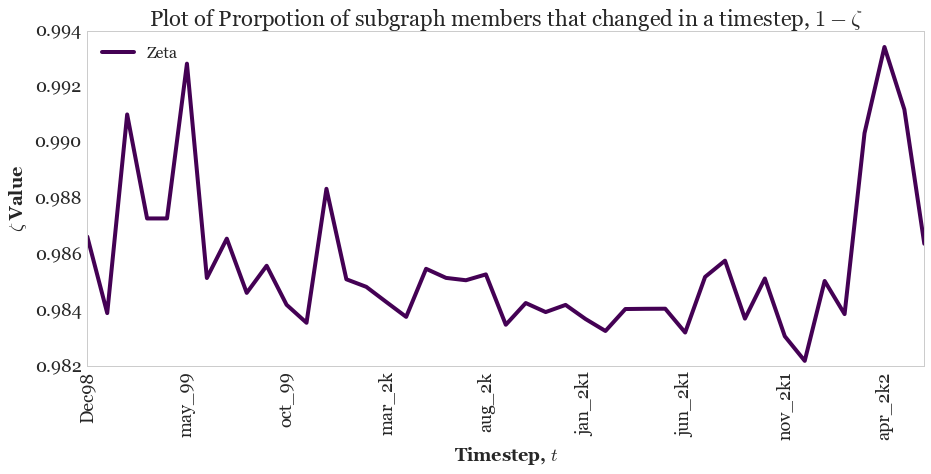

In [978]:
(1-zeta).plot(fontsize=18, cmap='viridis', rot =90)
plt.title("Plot of Prorpotion of subgraph members that changed in a timestep, $1-\zeta$", fontsize=22)
plt.xlabel("Timestep, $t$", fontsize=18)
plt.ylabel("$\zeta$ Value", fontsize=18)
plt.legend(fontsize=16, loc=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [988]:
np.mean(np.correlate(std_klpca_ratio(G_nov98),std_klpca_ratio(G_dec98)))

-0.7282589594178992

In [990]:
def avg_klpca_corr(net1,net2):
    avg = np.mean(np.correlate(std_klpca_ratio(net1),std_klpca_ratio(net2)))
    return avg
    

In [991]:
avg_klpca_corr(G_nov98,G_dec98)

-0.7282589594178992

In [992]:
avg_klpca3_corr = []
for i in range(0,len(all_graphs)-1):
    x = int(i)
    y = x +1
    avg_klpca3_corr.append(avg_klpca_corr(all_graphs[x],all_graphs[y]))

In [995]:
klpca = pd.DataFrame(avg_klpca3_corr,columns=['Avg KLPCA Corr'])

(array([ -6.00000000e+14,  -4.00000000e+14,  -2.00000000e+14,
          0.00000000e+00,   2.00000000e+14,   4.00000000e+14,
          6.00000000e+14]), <a list of 7 Text yticklabel objects>)

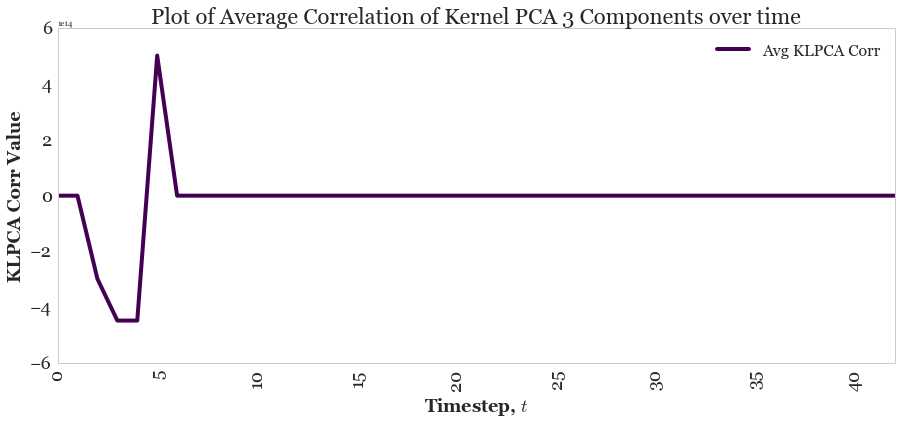

In [998]:
klpca.plot(fontsize=18, cmap='viridis', rot =90)
plt.title("Plot of Average Correlation of Kernel PCA 3 Components over time", fontsize=22)
plt.xlabel("Timestep, $t$", fontsize=18)
plt.ylabel("KLPCA Corr Value", fontsize=18)
plt.legend(fontsize=16, loc=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [1000]:
klpca=klpca.T
klpca.columns = list(stat_all.T.columns)[1:]
klpca=klpca.T
klpca.head()

Avg KLPCA Corr
Dec98    -7.282590e-01
jan_99    2.600181e+00
feb_99   -2.979981e+14
mar_99   -4.476561e+14
apr_99   -4.476561e+14

In [1004]:
(klpca - klpca.mean())/klpca.std()

Avg KLPCA Corr
Dec98          0.121836
jan_99         0.121836
feb_99        -2.137343
mar_99        -3.271929
apr_99        -3.271929
may_99         3.929607
jun_99         0.121836
jul_99         0.121836
aug_99         0.121836
sep_99         0.121836
oct_99         0.121836
nov_99         0.121836
dec_99         0.121836
jan_2k         0.121836
feb_2k         0.121836
mar_2k         0.121836
apr_2k         0.121836
may_2k         0.121836
jun_2k         0.121836
jul_2k         0.121836
aug_2k         0.121836
sep_2k         0.121836
oct_2k         0.121836
nov_2k         0.121836
dec_2k         0.121836
jan_2k1        0.121836
feb_2k1        0.121836
mar_2k1        0.121836
apr_2k1        0.121836
may_2k1        0.121836
jun_2k1        0.121836
jul_2k1        0.121836
aug_2k1        0.121836
sep_2k1        0.121836
oct_2k1        0.121836
nov_2k1        0.121836
dec_2k1        0.121836
jan_2k2        0.121836
feb_2k2        0.121836
mar_2k2        0.121836
apr_2k2        0.121836
may_2k2        0.121836
jun_2k2        0.121836